Imports


In [1]:
import numpy as np
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt




**Process DataSet**

In [2]:
# Colab-specific code (disabled for local execution)
# from google.colab import drive
# drive.mount('/content/drive')


def load_kmnist_data():
    """
    Loads the KMNIST train/test datasets and returns them as NumPy arrays.
    flattens each 28x28 image into a 784-dimensional row vector.
    """
    # 1. Load the data from the .npz files
    X_train = np.load("data/kmnist/kmnist-train-imgs.npz")["arr_0"]
    y_train = np.load("data/kmnist/kmnist-train-labels.npz")["arr_0"]

    X_test  = np.load("data/kmnist/kmnist-test-imgs.npz")["arr_0"]
    y_test  = np.load("data/kmnist/kmnist-test-labels.npz")["arr_0"]

    #flatten each 28x28 image into a 1x784 row vector for NN input

    N_train, H, W = X_train.shape
    X_train = X_train.reshape(N_train, H * W)

    N_test, H, W = X_test.shape
    X_test = X_test.reshape(N_test, H * W)

    return X_train, y_train, X_test, y_test

def preprocess_data(X_train, X_test):
    """
    Standardizes KMNIST data by subtracting the training mean and
    dividing by the training standard deviation
    """
    # Convert to float32
    X_train = X_train.astype(np.float32)
    X_test = X_test.astype(np.float32)

    # Compute the mean and standard deviation from the training data
    train_mean = np.mean(X_train, axis=0)
    train_std = np.std(X_train, axis=0) + 1e-7  # add small epsilon to avoid division-by-zero error

    # Apply the same normalization to both training and test sets
    X_train_norm = (X_train - train_mean) / train_std
    X_test_norm = (X_test - train_mean) / train_std

    return X_train_norm, X_test_norm

def create_train_val_split(X_train, y_train, val_size=0.1, random_seed=42):
    """
    Creates a validation split from the training data using stratified sampling.

    Args:
        X_train: Training data
        y_train: Training labels
        val_size: Size of validation set (fraction)
        random_seed: Random seed for reproducibility

    Returns:
        X_train_final, y_train_final, X_val, y_val
    """
    # Use stratified sampling to maintain class distribution
    X_train_final, X_val, y_train_final, y_val = train_test_split(
        X_train, y_train, test_size=val_size,
        stratify=y_train, random_state=random_seed
    )

    return X_train_final, y_train_final, X_val, y_val

def get_preprocessed_data(val_size=0.1, random_seed=42):
    """
    loads, preprocesses, and splits the data.

    Args:
        val_size: Size of validation set as a fraction
        random_seed: random seed

    Returns:
        X_train, y_train, X_val, y_val, X_test, y_test
    """
    # Load raw data
    X_train_raw, y_train_raw, X_test_raw, y_test = load_kmnist_data()

    # Preprocess data
    X_train_proc, X_test_proc = preprocess_data(X_train_raw, X_test_raw)

    # Create validation split
    X_train, y_train, X_val, y_val = create_train_val_split(
        X_train_proc, y_train_raw, val_size=val_size, random_seed=random_seed
    )

    return X_train, y_train, X_val, y_val, X_test_proc, y_test


# Just testing the data processing pipeline
if __name__ == "__main__":

    X_train, y_train, X_val, y_val, X_test, y_test = get_preprocessed_data()

    print("Data shapes:")
    print(f"  X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"  X_val:   {X_val.shape},   y_val:   {y_val.shape}")
    print(f"  X_test:  {X_test.shape},  y_test:  {y_test.shape}")

    # Verify data statistics
    print("\nData statistics, used in standardizing:")
    print(f"  X_train mean: {np.mean(X_train):.6f}, std: {np.std(X_train):.6f}")
    print(f"  X_val mean:   {np.mean(X_val):.6f},   std: {np.std(X_val):.6f}")
    print(f"  X_test mean:  {np.mean(X_test):.6f},  std: {np.std(X_test):.6f}")



Data shapes:
  X_train: (54000, 784), y_train: (54000,)
  X_val:   (6000, 784),   y_val:   (6000,)
  X_test:  (10000, 784),  y_test:  (10000,)

Data statistics, used in standardizing:
  X_train mean: 0.000048, std: 0.999815
  X_val mean:   -0.000436,   std: 1.001641
  X_test mean:  -0.017265,  std: 0.994266


**Task2 Basic MLP: Activation Functions**


In [3]:
#for after each hidden layer
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(np.float32)

def softmax(logits):
    # for last layer
    shifted = logits - np.max(logits, axis=1, keepdims=True)
    exp_vals = np.exp(shifted)
    return exp_vals / np.sum(exp_vals, axis=1, keepdims=True)

def one_hot_encode(y, num_classes):
    batch_size = y.shape[0]
    one_hot = np.zeros((batch_size, num_classes), dtype=np.float32)
    one_hot[np.arange(batch_size), y] = 1.0
    return one_hot

def evaluate_acc(y_true, y_pred):
    return np.mean(y_true == y_pred)

**Task2 Basic MLP: Class**

In [4]:
class BasicMLP:
    def __init__(self, random_seed=42):
        """
        Basic MLP model with 2 hidden layers:
        - Input: 784 dimensions
        - Hidden layers: [64, 64]
        - Output: 10 classes
        - Activation: ReLU
        - Weight initialization: He initialization
        """
        np.random.seed(random_seed)

        # architecture for model
        self.input_dim = 784
        self.hidden_layers = [64, 64]
        self.output_dim = 10
        self.activation = relu
        self.activation_deriv = relu_derivative

        # Network architecture
        self.layer_dims = [self.input_dim] + self.hidden_layers + [self.output_dim]


        # Initialize weights and biases with He initialization, for a layer with n inputs
        # the weights w are drawn from a distribution with variance 2/n. essentially a way to
        # tackle the problem of downstream vanishing or exploding gradients.
        # https://www.geeksforgeeks.org/kaiming-initialization-in-deep-learning/
        self.W = []
        self.b = []

        for i in range(len(self.layer_dims) - 1):
            in_dim = self.layer_dims[i]
            out_dim = self.layer_dims[i+1]


            scale = np.sqrt(2.0 / in_dim)
            W_i = scale * np.random.randn(in_dim, out_dim).astype(np.float32)
            b_i = np.zeros((1, out_dim), dtype=np.float32)

            self.W.append(W_i)
            self.b.append(b_i)

    def forward(self, X):
        """Forward pass through the network"""
        cache = {}
        cache['A0'] = X  # Input layer

        L = len(self.W)
        for i in range(L - 1):  # Hidden layers
            Z = cache[f'A{i}'] @ self.W[i] + self.b[i]  # Linear transformation
            A = self.activation(Z)  # Nonlinear activation
            cache[f'Z{i+1}'] = Z
            cache[f'A{i+1}'] = A

        # Output layer (logits)
        Z_final = cache[f'A{L-1}'] @ self.W[L-1] + self.b[L-1]
        cache[f'Z{L}'] = Z_final
        return Z_final, cache

    def compute_loss_and_grads(self, X, y_onehot):
        """Computes cross-entropy loss and gradients via backpropagation"""
        logits, cache = self.forward(X)
        probs = softmax(logits)

        batch_size = X.shape[0]

        # Cross-entropy loss
        loss = -np.sum(y_onehot * np.log(probs + 1e-8)) / batch_size

        grads = {}
        L = len(self.W)

        # Backpropagation for output layer
        dZ_final = (probs - y_onehot) / batch_size
        A_prev = cache[f'A{L-1}']
        grads[f'dW{L-1}'] = A_prev.T @ dZ_final
        grads[f'db{L-1}'] = np.sum(dZ_final, axis=0, keepdims=True)
        dA_prev = dZ_final @ self.W[L-1].T

        # Backpropagation for hidden layers
        for i in reversed(range(L - 1)):
            Z_i = cache[f'Z{i+1}']
            dZ_i = dA_prev * self.activation_deriv(Z_i)
            A_i_minus_1 = cache[f'A{i}']
            grads[f'dW{i}'] = A_i_minus_1.T @ dZ_i
            grads[f'db{i}'] = np.sum(dZ_i, axis=0, keepdims=True)
            if i > 0:
                dA_prev = dZ_i @ self.W[i].T

        return loss, grads

    def update_params(self, grads, lr):
        """Performs a gradient descent update on all parameters"""
        L = len(self.W)
        for i in range(L):
            self.W[i] -= lr * grads[f'dW{i}']
            self.b[i] -= lr * grads[f'db{i}']

    def fit(self, X_train, y_train, X_val=None, y_val=None, X_test=None, y_test=None,
        epochs=25, batch_size=128, lr=0.002, lr_decay=0.95, print_every=1):
        """
        Trains the MLP using mini-batch stocastic gradient descent.
        """
        num_samples = X_train.shape[0]
        y_train_oh = one_hot_encode(y_train, self.output_dim)

        train_losses = []
        train_accs = []
        val_accs = []
        test_accs = []

        for epoch in range(1, epochs+1):
            # Apply learning rate decay
            current_lr = lr * (lr_decay ** (epoch - 1))

            # Shuffle training data
            indices = np.random.permutation(num_samples)
            X_train_shuffled = X_train[indices]
            y_train_shuffled = y_train[indices]
            y_train_oh_shuffled = y_train_oh[indices]

            num_batches = num_samples // batch_size
            epoch_loss = 0.0

            for b in range(num_batches):
                start = b * batch_size
                end = start + batch_size
                X_batch = X_train_shuffled[start:end]
                y_batch = y_train_oh_shuffled[start:end]

                loss, grads = self.compute_loss_and_grads(X_batch, y_batch)
                epoch_loss += loss
                self.update_params(grads, current_lr)

            epoch_loss /= num_batches
            train_losses.append(epoch_loss)

            # Evaluate training accuracy
            if num_samples > 10000:
                eval_idx = np.random.choice(num_samples, 10000, replace=False)
                X_eval = X_train[eval_idx]
                y_eval = y_train[eval_idx]
            else:
                X_eval = X_train
                y_eval = y_train

            y_pred_train = self.predict(X_eval)
            train_acc = evaluate_acc(y_eval, y_pred_train)
            train_accs.append(train_acc)

            # Evaluate validation accuracy if provided
            val_acc = None
            if X_val is not None and y_val is not None:
                y_pred_val = self.predict(X_val)
                val_acc = evaluate_acc(y_val, y_pred_val)
                val_accs.append(val_acc)

            #test acc
            test_acc = None
            if X_test is not None and y_test is not None:
              y_pred_test = self.predict(X_test)
              test_acc = evaluate_acc(y_test, y_pred_test)
              test_accs.append(test_acc)


            if print_every > 0 and epoch % print_every == 0:
                val_msg = f"| Val Acc: {val_acc*100:.2f}%" if val_acc is not None else ""
                test_msg = f"| Test Acc: {test_acc*100:.2f}%" if test_acc is not None else ""
                print(f"Epoch {epoch}/{epochs} | LR: {current_lr:.6f} | Loss: {epoch_loss:.4f} | Train Acc: {train_acc*100:.2f}% {val_msg} {test_msg}")

        return {
            'train_losses': train_losses,
            'train_accs': train_accs,
            'val_accs': val_accs if X_val is not None else None,
            'test_accs': test_accs if X_test is not None else None
        }

    def predict(self, X):
        """Returns predicted class labels"""
        logits, _ = self.forward(X)
        probs = softmax(logits)
        return np.argmax(probs, axis=1)


if __name__ == "__main__":
    # Load and preprocess data
    X_train, y_train, X_val, y_val, X_test, y_test = get_preprocessed_data(val_size=0.1, random_seed=42)

    # Create and train the basic model
    print("Training the Basic MLP model:")
    print("Architecture: [64, 64]")
    print("Activation: ReLU")
    print("Weight initialization: He")

    # Calculate parameter count
    input_dim = 784
    hidden_layers = [64, 64]
    output_dim = 10
    params = (input_dim * hidden_layers[0] + hidden_layers[0]) + (hidden_layers[0] * hidden_layers[1] + hidden_layers[1]) + (hidden_layers[1] * output_dim + output_dim)
    print(f"Parameters: {params:,}")

    # Initialize the model
    model = BasicMLP(random_seed=42)

    # Train the model
    history = model.fit(
        X_train,
        y_train,
        X_val=X_val,
        y_val=y_val,
        X_test=X_test,
        y_test=y_test,
        epochs=25,
        batch_size=128,
        lr=0.002,
        lr_decay=0.95,
        print_every=1
    )

    # Evaluate on test set
    y_pred_test = model.predict(X_test)
    test_acc = evaluate_acc(y_test, y_pred_test)

    # Get final accuracies
    final_train_acc = history['train_accs'][-1]
    final_val_acc = history['val_accs'][-1]

    # Print final results
    print("\n===== FINAL RESULTS =====")
    print(f"Training accuracy:   {final_train_acc * 100:.2f}%")
    print(f"Validation accuracy: {final_val_acc * 100:.2f}%")
    print(f"Test accuracy:       {test_acc * 100:.2f}%")

Training the Basic MLP model:
Architecture: [64, 64]
Activation: ReLU
Weight initialization: He
Parameters: 55,050
Epoch 1/25 | LR: 0.002000 | Loss: 1.8259 | Train Acc: 58.54% | Val Acc: 58.65% | Test Acc: 42.34%
Epoch 2/25 | LR: 0.001900 | Loss: 1.1481 | Train Acc: 69.75% | Val Acc: 69.30% | Test Acc: 51.22%
Epoch 3/25 | LR: 0.001805 | Loss: 0.9250 | Train Acc: 73.85% | Val Acc: 73.45% | Test Acc: 55.84%
Epoch 4/25 | LR: 0.001715 | Loss: 0.8051 | Train Acc: 77.14% | Val Acc: 75.75% | Test Acc: 58.94%
Epoch 5/25 | LR: 0.001629 | Loss: 0.7288 | Train Acc: 78.59% | Val Acc: 77.57% | Test Acc: 60.98%
Epoch 6/25 | LR: 0.001548 | Loss: 0.6751 | Train Acc: 79.52% | Val Acc: 79.12% | Test Acc: 62.69%
Epoch 7/25 | LR: 0.001470 | Loss: 0.6348 | Train Acc: 81.02% | Val Acc: 80.32% | Test Acc: 63.99%
Epoch 8/25 | LR: 0.001397 | Loss: 0.6027 | Train Acc: 81.94% | Val Acc: 81.32% | Test Acc: 65.00%
Epoch 9/25 | LR: 0.001327 | Loss: 0.5770 | Train Acc: 82.77% | Val Acc: 82.05% | Test Acc: 65.89%
Epo

**Tuning the Learning Rate**


 Tuning LR = 0.001...

 Tuning LR = 0.05...

 Tuning LR = 0.1...

 Tuning LR = 0.5...

 Tuning LR = 1...

=== LR Tuning Summary ===
  LR = 0.001, Final Val Accuracy = 81.87%
  LR = 0.05, Final Val Accuracy = 93.48%
  LR = 0.1, Final Val Accuracy = 93.60%
  LR = 0.5, Final Val Accuracy = 94.47%
  LR = 1, Final Val Accuracy = 76.65%

[RESULT] Best LR: 0.5 with Val Accuracy = 94.47%



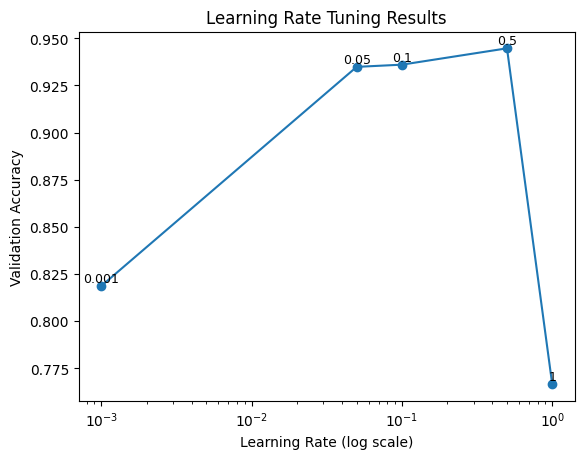

[INFO] Retraining final BasicMLP with best LR = 0.5
Epoch 1/25 | LR: 0.500000 | Loss: 0.4446 | Train Acc: 93.55% | Val Acc: 91.22% | Test Acc: 82.83%
Epoch 2/25 | LR: 0.475000 | Loss: 0.2250 | Train Acc: 94.31% | Val Acc: 91.98% | Test Acc: 84.32%
Epoch 3/25 | LR: 0.451250 | Loss: 0.1655 | Train Acc: 96.01% | Val Acc: 92.92% | Test Acc: 84.81%
Epoch 4/25 | LR: 0.428687 | Loss: 0.1334 | Train Acc: 96.08% | Val Acc: 92.63% | Test Acc: 85.60%
Epoch 5/25 | LR: 0.407253 | Loss: 0.1044 | Train Acc: 97.75% | Val Acc: 93.27% | Test Acc: 86.70%
Epoch 6/25 | LR: 0.386890 | Loss: 0.0796 | Train Acc: 97.47% | Val Acc: 93.03% | Test Acc: 86.10%
Epoch 7/25 | LR: 0.367546 | Loss: 0.0677 | Train Acc: 98.22% | Val Acc: 93.47% | Test Acc: 86.70%
Epoch 8/25 | LR: 0.349169 | Loss: 0.0536 | Train Acc: 98.36% | Val Acc: 93.15% | Test Acc: 86.47%
Epoch 9/25 | LR: 0.331710 | Loss: 0.0415 | Train Acc: 99.16% | Val Acc: 93.92% | Test Acc: 87.00%
Epoch 10/25 | LR: 0.315125 | Loss: 0.0266 | Train Acc: 99.54% | Va

In [5]:

def tune_learning_rate(X_train, y_train, X_val, y_val,
                       lr_candidates,
                       epochs=25,
                       batch_size=128,
                       lr_decay=0.95,
                       print_every=0,
                       random_seed=42):
    """
    Tuning procedure that tests multiple learning rates, trains a BasicMLP
    from scratch on each one, and returns the LR achieving the highest val accuracy.

    Args:
        X_train, y_train: Training data and labels
        X_val, y_val: Validation data and labels
        lr_candidates: List of candidate learning rates
        epochs: Number of epochs to train each model
        batch_size: Mini-batch size
        lr_decay: Decay factor for the learning rate each epoch
        print_every: Frequency of printing progress.
        random_seed: Random seed for reproducibility

    Returns:
        best_lr: The learning rate that yielded the highest final validation accuracy
        best_val_acc: The highest final validation accuracy
        results: A list of tuples (lr, final_val_acc) for each candidate
    """
    results = []
    best_lr = None
    best_val_acc = -1

    for lr in lr_candidates:
        print(f"\n Tuning LR = {lr}...")

        # Initialize new BasicMLP for each candidate
        model = BasicMLP(random_seed=random_seed)

        # Train the model
        history = model.fit(
            X_train,
            y_train,
            X_val=X_val,
            y_val=y_val,
            epochs=epochs,
            batch_size=batch_size,
            lr=lr,
            lr_decay=lr_decay,
            print_every=print_every
        )

        # Final validation accuracy after training. we choose optimal hyperparameter
        # based on val accuracies then apply on test later.
        final_val_acc = history['val_accs'][-1]
        results.append((lr, final_val_acc))

        # Track the best so far
        if final_val_acc > best_val_acc:
            best_val_acc = final_val_acc
            best_lr = lr

    print("\n=== LR Tuning Summary ===")
    for lr_val, acc_val in results:
        print(f"  LR = {lr_val}, Final Val Accuracy = {acc_val*100:.2f}%")
    print(f"\n[RESULT] Best LR: {best_lr} with Val Accuracy = {best_val_acc*100:.2f}%\n")

    # ===== Plot the results =====
    lr_vals, acc_vals = zip(*results)

    plt.figure()
    plt.plot(lr_vals, acc_vals, marker='o')
    plt.xscale('log')

    plt.xlabel('Learning Rate (log scale)')
    plt.ylabel('Validation Accuracy')
    plt.title('Learning Rate Tuning Results')

    # Label each point with its LR
    for x, y in zip(lr_vals, acc_vals):
        label_str = f"{x:.3g}"
        plt.text(x, y + 0.002, label_str, ha='center', fontsize=9)

    plt.show()
    # ===========================

    return best_lr, best_val_acc, results

if __name__ == "__main__":
    # 1. Load
    X_train, y_train, X_val, y_val, X_test, y_test = get_preprocessed_data(val_size=0.1, random_seed=42)

    #candidate LRs
    lr_candidates = [0.001, 0.05, 0.1, 0.5, 1]

    # 2. Run the tuning
    best_lr, best_val_acc, all_results = tune_learning_rate(
        X_train,
        y_train,
        X_val,
        y_val,
        lr_candidates,
        epochs=25,
        batch_size=128,
        lr_decay=0.95,
        print_every=0,
        random_seed=42
    )

    # 3. Retrain model using the best LR found
    print(f"[INFO] Retraining final BasicMLP with best LR = {best_lr}")
    final_model = BasicMLP(random_seed=42)
    final_history = final_model.fit(
        X_train,
        y_train,
        X_val=X_val,
        y_val=y_val,
        X_test=X_test,
        y_test=y_test,
        epochs=25,
        batch_size=128,
        lr=best_lr,
        lr_decay=0.95,
        print_every=1
    )

    # 4. View results
    final_val_accuracy = final_history['val_accs'][-1]
    final_test_accuracy = final_history['test_accs'][-1]
    print("\n===== FINAL MODEL RESULTS =====")
    print(f"  Best LR from tuning: {best_lr}")
    print(f"  Final Val Accuracy:  {final_val_accuracy*100:.2f}%")
    print(f"  Final Test Accuracy: {final_test_accuracy*100:.2f}%")


**Same model tuning regularization, batch size and dropout rate**

Training BasicMLPRegDrop with default hyperparameters (L2=1e-3, Dropout=0.1):
Parameters: 55,050
Epoch 1/25 | LR: 0.500000 | Loss: 0.8015 | Train Acc: 91.31% | Val Acc: 89.87% | Test Acc: 79.11%
Epoch 2/25 | LR: 0.475000 | Loss: 0.5334 | Train Acc: 93.62% | Val Acc: 91.23% | Test Acc: 82.55%
Epoch 3/25 | LR: 0.451250 | Loss: 0.4683 | Train Acc: 94.32% | Val Acc: 92.23% | Test Acc: 81.73%
Epoch 4/25 | LR: 0.428687 | Loss: 0.4285 | Train Acc: 94.43% | Val Acc: 92.42% | Test Acc: 83.74%
Epoch 5/25 | LR: 0.407253 | Loss: 0.4031 | Train Acc: 95.03% | Val Acc: 92.77% | Test Acc: 84.97%
Epoch 6/25 | LR: 0.386890 | Loss: 0.3888 | Train Acc: 94.62% | Val Acc: 92.50% | Test Acc: 84.22%
Epoch 7/25 | LR: 0.367546 | Loss: 0.3799 | Train Acc: 95.43% | Val Acc: 93.22% | Test Acc: 85.52%
Epoch 8/25 | LR: 0.349169 | Loss: 0.3677 | Train Acc: 95.80% | Val Acc: 93.03% | Test Acc: 85.04%
Epoch 9/25 | LR: 0.331710 | Loss: 0.3583 | Train Acc: 96.49% | Val Acc: 93.68% | Test Acc: 86.27%
Epoch 10/25 | LR: 0.3

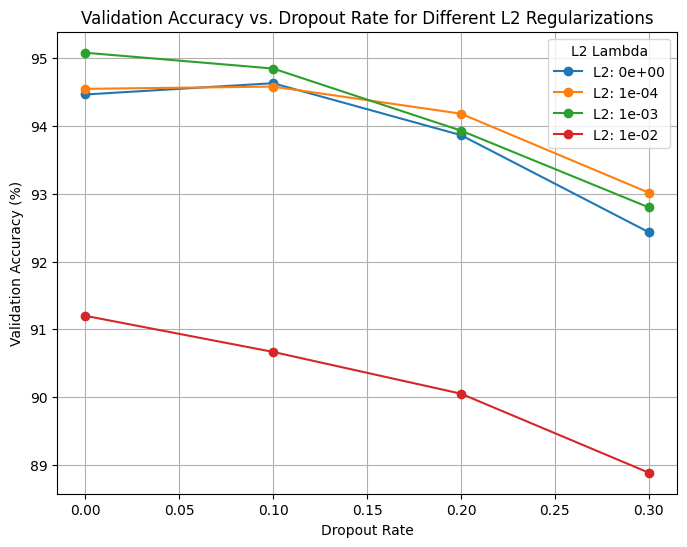

<Figure size 640x480 with 0 Axes>

In [6]:
class BasicMLPRegDrop:
    def __init__(self, random_seed=42, l2_lambda=0.0, dropout_rate=0.0):
        """
        same model as before with args for l2_lamda and dropout_rate.

        """
        np.random.seed(random_seed)

        # Model architecture
        self.input_dim = 784
        self.hidden_layers = [64, 64]
        self.output_dim = 10
        self.activation = relu
        self.activation_deriv = relu_derivative
        self.l2_lambda = l2_lambda
        self.dropout_rate = dropout_rate

        self.layer_dims = [self.input_dim] + self.hidden_layers + [self.output_dim]


        self.W = []
        self.b = []
        for i in range(len(self.layer_dims) - 1):
            in_dim = self.layer_dims[i]
            out_dim = self.layer_dims[i+1]
            scale = np.sqrt(2.0 / in_dim)
            W_i = scale * np.random.randn(in_dim, out_dim).astype(np.float32)
            b_i = np.zeros((1, out_dim), dtype=np.float32)
            self.W.append(W_i)
            self.b.append(b_i)

    def forward(self, X, training=True):
        """
        Forward pass.
        Applies dropout on hidden layers if training==True.
        """
        cache = {}
        cache['A0'] = X

        L = len(self.W)
        for i in range(L - 1):
            Z = cache[f'A{i}'] @ self.W[i] + self.b[i]
            A = self.activation(Z)
            if training and self.dropout_rate > 0:
                mask = (np.random.rand(*A.shape) > self.dropout_rate).astype(np.float32)
                A = A * mask / (1.0 - self.dropout_rate)
                cache[f'M{i+1}'] = mask
            cache[f'Z{i+1}'] = Z
            cache[f'A{i+1}'] = A

        # Output layer (no dropout)
        Z_final = cache[f'A{L-1}'] @ self.W[L-1] + self.b[L-1]
        cache[f'Z{L}'] = Z_final
        return Z_final, cache

    def compute_loss_and_grads(self, X, y_onehot):
        """
        Computes cross-entropy loss (with L2 penalty) and gradients via backpropagation.
        """
        logits, cache = self.forward(X, training=True)
        probs = softmax(logits)
        batch_size = X.shape[0]

        loss = -np.sum(y_onehot * np.log(probs + 1e-8)) / batch_size
        # Add L2 penalty here
        l2_sum = sum(np.sum(W_i**2) for W_i in self.W)
        loss += self.l2_lambda * l2_sum

        grads = {}
        L = len(self.W)
        dZ_final = (probs - y_onehot) / batch_size
        A_prev = cache[f'A{L-1}']
        grads[f'dW{L-1}'] = A_prev.T @ dZ_final
        grads[f'db{L-1}'] = np.sum(dZ_final, axis=0, keepdims=True)
        dA_prev = dZ_final @ self.W[L-1].T

        for i in reversed(range(L - 1)):
            Z_i = cache[f'Z{i+1}']
            dZ_i = dA_prev * self.activation_deriv(Z_i)
            if self.dropout_rate > 0 and f'M{i+1}' in cache:
                mask = cache[f'M{i+1}']
                dZ_i *= mask / (1.0 - self.dropout_rate)
            A_i_minus_1 = cache[f'A{i}']
            grads[f'dW{i}'] = A_i_minus_1.T @ dZ_i
            grads[f'db{i}'] = np.sum(dZ_i, axis=0, keepdims=True)
            if i > 0:
                dA_prev = dZ_i @ self.W[i].T

        # Add gradient for L2 penalty
        for i in range(L):
            grads[f'dW{i}'] += 2.0 * self.l2_lambda * self.W[i]

        return loss, grads

    def update_params(self, grads, lr):
        """Gradient descent update."""
        L = len(self.W)
        for i in range(L):
            self.W[i] -= lr * grads[f'dW{i}']
            self.b[i] -= lr * grads[f'db{i}']

    def fit(self, X_train, y_train, X_val=None, y_val=None, X_test=None, y_test=None,
            epochs=25, batch_size=128, lr_decay=0.95, print_every=1):
        """
        Trains the MLP using mini-batch SGD.
        Base learning rate is hardcoded to 0.5.
        """
        base_lr = 0.5
        num_samples = X_train.shape[0]
        y_train_oh = one_hot_encode(y_train, self.output_dim)

        train_losses, train_accs, val_accs, test_accs = [], [], [], []

        for epoch in range(1, epochs + 1):
            current_lr = base_lr * (lr_decay ** (epoch - 1))
            indices = np.random.permutation(num_samples)
            X_train_shuffled = X_train[indices]
            y_train_shuffled = y_train[indices]
            y_train_oh_shuffled = y_train_oh[indices]

            num_batches = num_samples // batch_size
            epoch_loss = 0.0

            for b in range(num_batches):
                start = b * batch_size
                end = start + batch_size
                X_batch = X_train_shuffled[start:end]
                y_batch = y_train_oh_shuffled[start:end]
                loss, grads = self.compute_loss_and_grads(X_batch, y_batch)
                epoch_loss += loss
                self.update_params(grads, current_lr)

            epoch_loss /= num_batches
            train_losses.append(epoch_loss)

            # Evaluate training accuracy
            if num_samples > 10000:
                eval_idx = np.random.choice(num_samples, 10000, replace=False)
                X_eval = X_train[eval_idx]
                y_eval = y_train[eval_idx]
            else:
                X_eval, y_eval = X_train, y_train

            y_pred_train = self.predict(X_eval)
            train_acc = evaluate_acc(y_eval, y_pred_train)
            train_accs.append(train_acc)

            if X_val is not None and y_val is not None:
                y_pred_val = self.predict(X_val)
                val_acc = evaluate_acc(y_val, y_pred_val)
                val_accs.append(val_acc)
            else:
                val_acc = None

            if X_test is not None and y_test is not None:
                y_pred_test = self.predict(X_test)
                test_acc = evaluate_acc(y_test, y_pred_test)
                test_accs.append(test_acc)
            else:
                test_acc = None

            if print_every > 0 and epoch % print_every == 0:
                val_msg = f"| Val Acc: {val_acc*100:.2f}%" if val_acc is not None else ""
                test_msg = f"| Test Acc: {test_acc*100:.2f}%" if test_acc is not None else ""
                print(f"Epoch {epoch}/{epochs} | LR: {current_lr:.6f} | Loss: {epoch_loss:.4f} | "
                      f"Train Acc: {train_acc*100:.2f}% {val_msg} {test_msg}")

        return {
            'train_losses': train_losses,
            'train_accs': train_accs,
            'val_accs': val_accs if X_val is not None else None,
            'test_accs': test_accs if X_test is not None else None
        }

    def predict(self, X):

        logits, _ = self.forward(X, training=False)
        probs = softmax(logits)
        return np.argmax(probs, axis=1)

def tune_overfitting_hparams(
    X_train, y_train, X_val, y_val, X_test, y_test,
    l2_candidates=[0.0, 1e-4, 1e-3, 1e-2],
    dropout_candidates=[0.0, 0.1, 0.2, 0.3],
    batch_sizes=[128],
    epochs=25,
    lr_decay=0.95,
    print_every=0,
    random_seed=42
):

    results = []
    best_val_acc = -1
    best_config = {}

    for l2 in l2_candidates:
        for dropout in dropout_candidates:
            for bs in batch_sizes:
                print(f"\n[INFO] Tuning with L2 = {l2}, Dropout = {dropout}, Batch Size = {bs}")
                model = BasicMLPRegDrop(random_seed=random_seed, l2_lambda=l2, dropout_rate=dropout)
                history = model.fit(
                    X_train, y_train,
                    X_val=X_val, y_val=y_val,
                    X_test=X_test, y_test=y_test,
                    epochs=epochs, batch_size=bs,
                    lr_decay=lr_decay, print_every=print_every
                )
                final_val_acc = history['val_accs'][-1]
                results.append((l2, dropout, bs, final_val_acc))
                print(f"Final Val Acc: {final_val_acc*100:.2f}%")
                if final_val_acc > best_val_acc:
                    best_val_acc = final_val_acc
                    best_config = {"l2_lambda": l2, "dropout_rate": dropout, "batch_size": bs}

    print("\n=== Tuning Summary ===")
    for (l2, dropout, bs, acc) in results:
        print(f"L2: {l2}, Dropout: {dropout}, Batch Size: {bs} -> Val Acc: {acc*100:.2f}%")
    print(f"\n[RESULT] Best Config: {best_config} with Val Acc: {best_val_acc*100:.2f}%\n")

    return best_config, best_val_acc, results

if __name__ == "__main__":
    # Load and preprocess data
    X_train, y_train, X_val, y_val, X_test, y_test = get_preprocessed_data(val_size=0.1, random_seed=42)

    print("Training BasicMLPRegDrop with default hyperparameters (L2=1e-3, Dropout=0.1):")
    input_dim, hidden_layers, output_dim = 784, [64, 64], 10
    params = (input_dim * hidden_layers[0] + hidden_layers[0]) + \
             (hidden_layers[0] * hidden_layers[1] + hidden_layers[1]) + \
             (hidden_layers[1] * output_dim + output_dim)
    print(f"Parameters: {params:,}")

    # Train model with default settings
    model_default = BasicMLPRegDrop(random_seed=42, l2_lambda=1e-3, dropout_rate=0.1)
    history_default = model_default.fit(
        X_train, y_train,
        X_val=X_val, y_val=y_val,
        X_test=X_test, y_test=y_test,
        epochs=25,
        batch_size=128,
        lr_decay=0.95,
        print_every=1
    )
    y_pred_test_default = model_default.predict(X_test)
    test_acc_default = evaluate_acc(y_test, y_pred_test_default)
    final_train_acc_default = history_default['train_accs'][-1]
    final_val_acc_default = history_default['val_accs'][-1]
    print("\n===== DEFAULT MODEL RESULTS =====")
    print(f"Training accuracy:   {final_train_acc_default*100:.2f}%")
    print(f"Validation accuracy: {final_val_acc_default*100:.2f}%")
    print(f"Test accuracy:       {test_acc_default*100:.2f}%")

    # ---------------- Hyperparameter Tuning ----------------
    print("\n\n[TUNING] Tuning L2 regularization and Dropout to reduce overfitting...")
    best_config, best_val_acc, tuning_results = tune_overfitting_hparams(
        X_train, y_train, X_val, y_val, X_test, y_test,
        l2_candidates=[0.0, 1e-4, 1e-3, 1e-2],
        dropout_candidates=[0.0, 0.1, 0.2, 0.3],
        batch_sizes=[128],
        epochs=25,
        lr_decay=0.95,
        print_every=0,
        random_seed=42
    )

    # Retrain final model using best hyperparameters
    print("\n[INFO] Retraining final model with best hyperparameters:")
    print(best_config)
    final_model = BasicMLPRegDrop(
        random_seed=42,
        l2_lambda=best_config["l2_lambda"],
        dropout_rate=best_config["dropout_rate"]
    )
    final_history = final_model.fit(
        X_train, y_train,
        X_val=X_val, y_val=y_val,
        X_test=X_test, y_test=y_test,
        epochs=25,
        batch_size=best_config["batch_size"],
        lr_decay=0.95,
        print_every=1
    )
    final_val_acc = final_history['val_accs'][-1]
    final_test_acc = final_history['test_accs'][-1]
    print("\n===== FINAL MODEL RESULTS =====")
    print(f"Best hyperparameters: {best_config}")
    print(f"Final Validation Accuracy: {final_val_acc*100:.2f}%")
    print(f"Final Test Accuracy: {final_test_acc*100:.2f}%")


    l2_values = sorted(set([res[0] for res in tuning_results]))
    dropout_values = sorted(set([res[1] for res in tuning_results]))

    plt.figure(figsize=(8,6))
    for l2 in l2_values:
        accs = []
        d_vals = []
        # For each dropout candidate, find the corresponding final validation accuracy
        # for the given l2
        for d in dropout_values:
            matching = [res[3] for res in tuning_results if res[0] == l2 and res[1] == d]
            if matching:
                avg_acc = np.mean(matching)
                accs.append(avg_acc * 100)
                d_vals.append(d)
        if d_vals:
            plt.plot(d_vals, accs, marker='o', label=f"L2: {l2:.0e}")

    plt.xlabel("Dropout Rate")
    plt.ylabel("Validation Accuracy (%)")
    plt.title("Validation Accuracy vs. Dropout Rate for Different L2 Regularizations")
    plt.legend(title="L2 Lambda")
    plt.grid(True)
    plt.show()

    plt.savefig("tuning2.png", dpi=300)
#     from google.colab import files
#     files.download("tuning2.png")

decay experiment

In [7]:
# Load and preprocess the data
X_train, y_train, X_val, y_val, X_test, y_test = get_preprocessed_data(val_size=0.1, random_seed=42)

print("=== Experiment 1: lr = 0.5 with lr_decay = 0.95 ===")
model_decay = BasicMLP(random_seed=42)
history_decay = model_decay.fit(
    X_train, y_train,
    X_val=X_val, y_val=y_val,
    X_test=X_test, y_test=y_test,
    epochs=25,
    batch_size=128,
    lr=0.5,
    lr_decay=0.95,   # default decay
    print_every=1
)

print("\n=== Experiment 2: lr = 0.5 with no decay (lr_decay = 1.0) ===")
model_nodecay = BasicMLP(random_seed=42)
history_nodecay = model_nodecay.fit(
    X_train, y_train,
    X_val=X_val, y_val=y_val,
    X_test=X_test, y_test=y_test,
    epochs=25,
    batch_size=128,
    lr=0.5,
    lr_decay=1.0,   # no decay
    print_every=1
)


train_acc_decay = history_decay['train_accs'][-1]
val_acc_decay   = history_decay['val_accs'][-1]
test_acc_decay  = history_decay['test_accs'][-1]

train_acc_nodecay = history_nodecay['train_accs'][-1]
val_acc_nodecay   = history_nodecay['val_accs'][-1]
test_acc_nodecay  = history_nodecay['test_accs'][-1]


print("\n===== Comparison of Experiments =====")
print("Experiment 1 (lr_decay = 0.95):")
print(f"  Training Accuracy:   {train_acc_decay*100:.2f}%")
print(f"  Validation Accuracy: {val_acc_decay*100:.2f}%")
print(f"  Test Accuracy:       {test_acc_decay*100:.2f}%\n")

print("Experiment 2 (no decay, lr_decay = 1.0):")
print(f"  Training Accuracy:   {train_acc_nodecay*100:.2f}%")
print(f"  Validation Accuracy: {val_acc_nodecay*100:.2f}%")
print(f"  Test Accuracy:       {test_acc_nodecay*100:.2f}%")


=== Experiment 1: lr = 0.5 with lr_decay = 0.95 ===
Epoch 1/25 | LR: 0.500000 | Loss: 0.4446 | Train Acc: 93.55% | Val Acc: 91.22% | Test Acc: 82.83%
Epoch 2/25 | LR: 0.475000 | Loss: 0.2250 | Train Acc: 94.31% | Val Acc: 91.98% | Test Acc: 84.32%
Epoch 3/25 | LR: 0.451250 | Loss: 0.1655 | Train Acc: 96.01% | Val Acc: 92.92% | Test Acc: 84.81%
Epoch 4/25 | LR: 0.428687 | Loss: 0.1334 | Train Acc: 96.08% | Val Acc: 92.63% | Test Acc: 85.60%
Epoch 5/25 | LR: 0.407253 | Loss: 0.1044 | Train Acc: 97.75% | Val Acc: 93.27% | Test Acc: 86.70%
Epoch 6/25 | LR: 0.386890 | Loss: 0.0796 | Train Acc: 97.47% | Val Acc: 93.03% | Test Acc: 86.10%
Epoch 7/25 | LR: 0.367546 | Loss: 0.0677 | Train Acc: 98.22% | Val Acc: 93.47% | Test Acc: 86.70%
Epoch 8/25 | LR: 0.349169 | Loss: 0.0536 | Train Acc: 98.36% | Val Acc: 93.15% | Test Acc: 86.47%
Epoch 9/25 | LR: 0.331710 | Loss: 0.0415 | Train Acc: 99.16% | Val Acc: 93.92% | Test Acc: 87.00%
Epoch 10/25 | LR: 0.315125 | Loss: 0.0266 | Train Acc: 99.54% | Va

**Task2: Gradient Checking**

In [8]:
def gradient_checking(model, X, y, epsilon=1e-7):
    """
    Verify the gradient computation by comparing the analytical gradients from
    backpropagation with numerical gradients from finite difference method.

    Parameters:
    - model: the BasicMLP model
    - X: input data sample (small batch)
    - y: labels for the input data
    - epsilon: small perturbation value

    Returns:
    - diff_list: list of relative differences between analytical and numerical gradients
    - param_names: names of the parameters checked
    """
    # Convert labels to one-hot encoding
    y_one_hot = one_hot_encode(y, model.output_dim)

    # Compute gradients analytically using backpropagation
    _, analytical_grads = model.compute_loss_and_grads(X, y_one_hot)

    # Initialize lists to store differences and parameter names
    diff_list = []
    param_names = []

    # Check gradients for each parameter
    for i in range(len(model.W)):
        # Check gradients for W
        dW_analytical = analytical_grads[f'dW{i}']
        W_shape = dW_analytical.shape

        # Create a flattened copy of the weight matrix for numerical gradient calculation
        W_flat = model.W[i].flatten()
        dW_numerical_flat = np.zeros_like(W_flat)

        # Compute numerical gradients for each weight
        for j in range(len(W_flat)):
            # Create copies of all weights
            W_all = [w.copy() for w in model.W]
            b_all = [b.copy() for b in model.b]

            # Save original value
            orig_value = W_flat[j]

            # Compute loss with a small positive perturbation
            W_flat[j] = orig_value + epsilon
            W_all[i] = W_flat.reshape(W_shape)

            # Set temporary values to the model
            temp_W, temp_b = model.W, model.b
            model.W, model.b = W_all, b_all

            logits_plus, _ = model.forward(X)
            probs_plus = softmax(logits_plus)
            loss_plus = -np.sum(y_one_hot * np.log(probs_plus + 1e-8)) / X.shape[0]

            # Compute loss with a small negative perturbation
            W_flat[j] = orig_value - epsilon
            W_all[i] = W_flat.reshape(W_shape)
            model.W = W_all

            logits_minus, _ = model.forward(X)
            probs_minus = softmax(logits_minus)
            loss_minus = -np.sum(y_one_hot * np.log(probs_minus + 1e-8)) / X.shape[0]

            # Calculate symmetric difference quotient: (f(x+h) - f(x-h))/2h
            dW_numerical_flat[j] = (loss_plus - loss_minus) / (2 * epsilon)

            # Restore original value
            W_flat[j] = orig_value

            # Restore original model parameters
            model.W, model.b = temp_W, temp_b

        # Reshape numerical gradient to match analytical gradient
        dW_numerical = dW_numerical_flat.reshape(W_shape)

        # Compute relative difference
        diff = np.linalg.norm(dW_analytical - dW_numerical) / (
            np.linalg.norm(dW_analytical) + np.linalg.norm(dW_numerical) + 1e-9)

        diff_list.append(diff)
        param_names.append(f'W{i}')

        # Check gradients for b
        db_analytical = analytical_grads[f'db{i}']
        b_shape = db_analytical.shape

        # Create a flattened copy of the bias vector for numerical gradient calculation
        b_flat = model.b[i].flatten()
        db_numerical_flat = np.zeros_like(b_flat)

        # Compute numerical gradients for each bias
        for j in range(len(b_flat)):
            # Create copies of all weights and biases
            W_all = [w.copy() for w in model.W]
            b_all = [b.copy() for b in model.b]

            # Save original value
            orig_value = b_flat[j]

            # Compute loss with a small positive perturbation
            b_flat[j] = orig_value + epsilon
            b_all[i] = b_flat.reshape(b_shape)

            # Set temporary values to the model
            temp_W, temp_b = model.W, model.b
            model.W, model.b = W_all, b_all

            logits_plus, _ = model.forward(X)
            probs_plus = softmax(logits_plus)
            loss_plus = -np.sum(y_one_hot * np.log(probs_plus + 1e-8)) / X.shape[0]

            # Compute loss with a small negative perturbation
            b_flat[j] = orig_value - epsilon
            b_all[i] = b_flat.reshape(b_shape)
            model.W, model.b = W_all, b_all

            logits_minus, _ = model.forward(X)
            probs_minus = softmax(logits_minus)
            loss_minus = -np.sum(y_one_hot * np.log(probs_minus + 1e-8)) / X.shape[0]

            # Calculate symmetric difference quotient
            db_numerical_flat[j] = (loss_plus - loss_minus) / (2 * epsilon)

            # Restore original value
            b_flat[j] = orig_value

            # Restore original model parameters
            model.W, model.b = temp_W, temp_b

        # Reshape numerical gradient to match analytical gradient
        db_numerical = db_numerical_flat.reshape(b_shape)

        # Compute relative difference
        diff = np.linalg.norm(db_analytical - db_numerical) / (
            np.linalg.norm(db_analytical) + np.linalg.norm(db_numerical) + 1e-9)

        diff_list.append(diff)
        param_names.append(f'b{i}')

    return diff_list, param_names

def run_gradient_check():
    """
    Run gradient checking on a small subset of data
    """

    # Load a very small subset of data for gradient checking
    X_train, y_train, _, _, _, _ = get_preprocessed_data(val_size=0.1, random_seed=42)

    # Use a small batch for efficiency
    batch_size = 10
    indices = np.random.choice(X_train.shape[0], batch_size, replace=False)
    X_sample = X_train[indices]
    y_sample = y_train[indices]

    # Initialize the model
    model = BasicMLP(random_seed=42)

    diff_list, param_names = gradient_checking(model, X_sample, y_sample)

    # Print results
    print("\nGradient Check Results:")

    for name, diff in zip(param_names, diff_list):
        print(f"Parameter {name}: difference = {diff:.8f}")

    # Check if gradients are correct (if diff < 1e-5 then consider it correct)
    threshold = 1e-5
    all_correct = all(diff < threshold for diff in diff_list)

    if all_correct:
        print("\nAll gradients verified.")
    else:
        print("\n Gradients don't match the numerical approximation, incorrect calculations")
        print(f"Check parameters with difference > {threshold}.")

if __name__ == "__main__":
    run_gradient_check()


Gradient Check Results:
Parameter W0: difference = 0.00000195
Parameter b0: difference = 0.00000176
Parameter W1: difference = 0.00000198
Parameter b1: difference = 0.00000159
Parameter W2: difference = 0.00000185
Parameter b2: difference = 0.00000175

All gradients verified.


**Task3.1: MLP with no hidden layer**

In [9]:
class NoHiddenLayerMLP(BasicMLP):
    def __init__(self, random_seed=42):
        """MLP model with no hidden layers (logistic regression)"""
        np.random.seed(random_seed)

        self.input_dim = 784
        self.output_dim = 10

        # Xavier initialization instead of he
        scale = np.sqrt(1.0 / self.input_dim)
        self.W = scale * np.random.randn(self.input_dim, self.output_dim).astype(np.float32)
        self.b = np.zeros((1, self.output_dim), dtype=np.float32)

    def forward(self, X):
        """Forward pass through the network"""
        Z = X @ self.W + self.b
        return Z

    def compute_loss_and_grads(self, X, y_onehot):
        """Computes cross-entropy loss and gradients"""
        batch_size = X.shape[0]

        logits = self.forward(X)
        probs = softmax(logits)

        loss = -np.sum(y_onehot * np.log(probs + 1e-8)) / batch_size

        dZ = (probs - y_onehot) / batch_size
        dW = X.T @ dZ
        db = np.sum(dZ, axis=0, keepdims=True)

        return loss, {'dW': dW, 'db': db}

    def update_params(self, grads, lr):
        """Performs a gradient descent update on parameters"""
        self.W -= lr * grads['dW']
        self.b -= lr * grads['db']

    def predict(self, X):
        """Returns predicted class labels"""
        logits = self.forward(X)
        probs = softmax(logits)
        return np.argmax(probs, axis=1)

# Training and evaluation code
if __name__ == "__main__":
    X_train, y_train, X_val, y_val, X_test, y_test = get_preprocessed_data(val_size=0.1, random_seed=42)

    print("Model: MLP with No Hidden Layers (Logistic Regression)")

    # Calculate parameter count
    params = 784 * 10 + 10
    print(f"Parameters: {params:,}")

    model = NoHiddenLayerMLP(random_seed=42)

    history = model.fit(
        X_train, y_train,
        X_val=X_val, y_val=y_val,
        X_test=X_test, y_test=y_test,
        epochs=25, batch_size=128,
        lr=0.5, lr_decay=0.95,
        print_every=1
    )

    # Evaluate on test set
    y_pred_test = model.predict(X_test)
    test_acc = evaluate_acc(y_test, y_pred_test)

    print(f"\n===== FINAL RESULTS =====")
    print(f"Training accuracy:   {history['train_accs'][-1] * 100:.2f}%")
    print(f"Validation accuracy: {history['val_accs'][-1] * 100:.2f}%")
    print(f"Test accuracy:       {test_acc * 100:.2f}%")

Model: MLP with No Hidden Layers (Logistic Regression)
Parameters: 7,850
Epoch 1/25 | LR: 0.500000 | Loss: 0.9873 | Train Acc: 79.54% | Val Acc: 77.20% | Test Acc: 65.66%
Epoch 2/25 | LR: 0.475000 | Loss: 0.8904 | Train Acc: 78.58% | Val Acc: 76.78% | Test Acc: 66.23%
Epoch 3/25 | LR: 0.451250 | Loss: 0.8613 | Train Acc: 79.43% | Val Acc: 77.45% | Test Acc: 64.21%
Epoch 4/25 | LR: 0.428687 | Loss: 0.8189 | Train Acc: 80.09% | Val Acc: 77.07% | Test Acc: 64.04%
Epoch 5/25 | LR: 0.407253 | Loss: 0.7920 | Train Acc: 80.46% | Val Acc: 77.52% | Test Acc: 66.41%
Epoch 6/25 | LR: 0.386890 | Loss: 0.7693 | Train Acc: 79.08% | Val Acc: 76.40% | Test Acc: 63.83%
Epoch 7/25 | LR: 0.367546 | Loss: 0.7482 | Train Acc: 81.21% | Val Acc: 77.78% | Test Acc: 65.30%
Epoch 8/25 | LR: 0.349169 | Loss: 0.7320 | Train Acc: 79.59% | Val Acc: 76.80% | Test Acc: 64.56%
Epoch 9/25 | LR: 0.331710 | Loss: 0.7128 | Train Acc: 82.23% | Val Acc: 78.28% | Test Acc: 65.91%
Epoch 10/25 | LR: 0.315125 | Loss: 0.6999 | T

**Task3.1: Single Hidden Layer MLP**

In [10]:
class SingleHiddenLayerMLP(BasicMLP):
    def __init__(self, hidden_units=64, random_seed=42):
        """MLP model with a single hidden layer"""
        np.random.seed(random_seed)

        self.input_dim = 784
        self.hidden_dim = hidden_units
        self.output_dim = 10

        # He initialization for ReLU
        scale1 = np.sqrt(2.0 / self.input_dim)
        self.W1 = scale1 * np.random.randn(self.input_dim, self.hidden_dim).astype(np.float32)
        self.b1 = np.zeros((1, self.hidden_dim), dtype=np.float32)

        # Xavier initialization for output layer
        scale2 = np.sqrt(1.0 / self.hidden_dim)
        self.W2 = scale2 * np.random.randn(self.hidden_dim, self.output_dim).astype(np.float32)
        self.b2 = np.zeros((1, self.output_dim), dtype=np.float32)

    def forward(self, X):
        """Forward pass through the network"""
        # Hidden layer
        Z1 = X @ self.W1 + self.b1
        A1 = relu(Z1)

        # Output layer
        Z2 = A1 @ self.W2 + self.b2

        # Store activations for backpropagation
        self.cache = {'X': X, 'Z1': Z1, 'A1': A1}

        return Z2

    def compute_loss_and_grads(self, X, y_onehot):
        """Computes cross-entropy loss and gradients"""
        batch_size = X.shape[0]

        logits = self.forward(X)
        probs = softmax(logits)

        loss = -np.sum(y_onehot * np.log(probs + 1e-8)) / batch_size

        # Output layer gradients
        dZ2 = (probs - y_onehot) / batch_size
        dW2 = self.cache['A1'].T @ dZ2
        db2 = np.sum(dZ2, axis=0, keepdims=True)

        # Hidden layer gradients
        dA1 = dZ2 @ self.W2.T
        dZ1 = dA1 * relu_derivative(self.cache['Z1'])
        dW1 = self.cache['X'].T @ dZ1
        db1 = np.sum(dZ1, axis=0, keepdims=True)

        return loss, {'dW1': dW1, 'db1': db1, 'dW2': dW2, 'db2': db2}

    def update_params(self, grads, lr):
        """Performs a gradient descent update on parameters"""
        self.W1 -= lr * grads['dW1']
        self.b1 -= lr * grads['db1']
        self.W2 -= lr * grads['dW2']
        self.b2 -= lr * grads['db2']

    def predict(self, X):
        """Returns predicted class labels"""
        logits = self.forward(X)
        probs = softmax(logits)
        return np.argmax(probs, axis=1)

# Training and evaluation code
if __name__ == "__main__":
    X_train, y_train, X_val, y_val, X_test, y_test = get_preprocessed_data(val_size=0.1, random_seed=42)

    # Try different hidden layer sizes
    hidden_units_options = [32, 64, 128, 256]
    results = []

    for hidden_units in hidden_units_options:
        print(f"\n===== Training MLP with Single Hidden Layer ({hidden_units} units) =====")

        # Calculate parameter count
        params = (784 * hidden_units + hidden_units) + (hidden_units * 10 + 10)
        print(f"Parameters: {params:,}")

        model = SingleHiddenLayerMLP(hidden_units=hidden_units, random_seed=42)

        history = model.fit(
            X_train, y_train,
            X_val=X_val, y_val=y_val,
            X_test=X_test, y_test=y_test,
            epochs=25, batch_size=128,
            lr=0.5, lr_decay=0.95,
            print_every=1
        )

        # Evaluate on test set
        y_pred_test = model.predict(X_test)
        test_acc = evaluate_acc(y_test, y_pred_test)

        # Get final accuracies
        final_train_acc = history['train_accs'][-1]
        final_val_acc = history['val_accs'][-1]

        print(f"\n===== FINAL RESULTS =====")
        print(f"Hidden units: {hidden_units}")
        print(f"Training accuracy:   {final_train_acc * 100:.2f}%")
        print(f"Validation accuracy: {final_val_acc * 100:.2f}%")
        print(f"Test accuracy:       {test_acc * 100:.2f}%")

        results.append({
            'hidden_units': hidden_units,
            'params': params,
            'train_acc': final_train_acc,
            'val_acc': final_val_acc,
            'test_acc': test_acc,
            'train_losses': history['train_losses'],
            'train_accs': history['train_accs'],
            'val_accs': history['val_accs']
        })

    # Find the best model based on validation accuracy
    best_model_idx = np.argmax([r['val_acc'] for r in results])
    best_model = results[best_model_idx]

    print(f"\n===== BEST SINGLE HIDDEN LAYER MODEL =====")
    print(f"Hidden units: {best_model['hidden_units']}")
    print(f"Parameters: {best_model['params']:,}")
    print(f"Training accuracy:   {best_model['train_acc'] * 100:.2f}%")
    print(f"Validation accuracy: {best_model['val_acc'] * 100:.2f}%")
    print(f"Test accuracy:       {best_model['test_acc'] * 100:.2f}%")


===== Training MLP with Single Hidden Layer (32 units) =====
Parameters: 25,450
Epoch 1/25 | LR: 0.500000 | Loss: 0.5762 | Train Acc: 86.76% | Val Acc: 85.57% | Test Acc: 74.41%
Epoch 2/25 | LR: 0.475000 | Loss: 0.3689 | Train Acc: 92.25% | Val Acc: 89.87% | Test Acc: 79.26%
Epoch 3/25 | LR: 0.451250 | Loss: 0.3090 | Train Acc: 92.90% | Val Acc: 89.10% | Test Acc: 79.44%
Epoch 4/25 | LR: 0.428687 | Loss: 0.2853 | Train Acc: 93.19% | Val Acc: 89.43% | Test Acc: 80.43%
Epoch 5/25 | LR: 0.407253 | Loss: 0.2461 | Train Acc: 93.26% | Val Acc: 89.42% | Test Acc: 80.26%
Epoch 6/25 | LR: 0.386890 | Loss: 0.2206 | Train Acc: 94.46% | Val Acc: 90.53% | Test Acc: 81.17%
Epoch 7/25 | LR: 0.367546 | Loss: 0.2001 | Train Acc: 94.98% | Val Acc: 90.50% | Test Acc: 82.12%
Epoch 8/25 | LR: 0.349169 | Loss: 0.1825 | Train Acc: 95.29% | Val Acc: 90.43% | Test Acc: 81.67%
Epoch 9/25 | LR: 0.331710 | Loss: 0.1664 | Train Acc: 95.56% | Val Acc: 90.42% | Test Acc: 81.27%
Epoch 10/25 | LR: 0.315125 | Loss: 0.

Task3.1: Double Hidden Layer MLP


In [11]:
class TwoHiddenLayerMLP(BasicMLP):
    def __init__(self, hidden_units=64, random_seed=42):
        """MLP model with two hidden layers"""
        np.random.seed(random_seed)

        self.input_dim = 784
        self.hidden_dim = hidden_units
        self.output_dim = 10

        # He initialization for ReLU
        # Layer 1
        scale1 = np.sqrt(2.0 / self.input_dim)
        self.W1 = scale1 * np.random.randn(self.input_dim, self.hidden_dim).astype(np.float32)
        self.b1 = np.zeros((1, self.hidden_dim), dtype=np.float32)

        # Layer 2
        scale2 = np.sqrt(2.0 / self.hidden_dim)
        self.W2 = scale2 * np.random.randn(self.hidden_dim, self.hidden_dim).astype(np.float32)
        self.b2 = np.zeros((1, self.hidden_dim), dtype=np.float32)

        # Output layer
        scale3 = np.sqrt(1.0 / self.hidden_dim)
        self.W3 = scale3 * np.random.randn(self.hidden_dim, self.output_dim).astype(np.float32)
        self.b3 = np.zeros((1, self.output_dim), dtype=np.float32)

    def forward(self, X):
        """Forward pass through the network"""
        # Hidden layer 1
        Z1 = X @ self.W1 + self.b1
        A1 = relu(Z1)

        # Hidden layer 2
        Z2 = A1 @ self.W2 + self.b2
        A2 = relu(Z2)

        # Output layer
        Z3 = A2 @ self.W3 + self.b3

        # Store activations for backpropagation
        self.cache = {'X': X, 'Z1': Z1, 'A1': A1, 'Z2': Z2, 'A2': A2}

        return Z3

    def compute_loss_and_grads(self, X, y_onehot):
        """Computes cross-entropy loss and gradients"""
        batch_size = X.shape[0]

        logits = self.forward(X)
        probs = softmax(logits)

        loss = -np.sum(y_onehot * np.log(probs + 1e-8)) / batch_size

        # Output layer gradients
        dZ3 = (probs - y_onehot) / batch_size
        dW3 = self.cache['A2'].T @ dZ3
        db3 = np.sum(dZ3, axis=0, keepdims=True)

        # Hidden layer 2 gradients
        dA2 = dZ3 @ self.W3.T
        dZ2 = dA2 * relu_derivative(self.cache['Z2'])
        dW2 = self.cache['A1'].T @ dZ2
        db2 = np.sum(dZ2, axis=0, keepdims=True)

        # Hidden layer 1 gradients
        dA1 = dZ2 @ self.W2.T
        dZ1 = dA1 * relu_derivative(self.cache['Z1'])
        dW1 = self.cache['X'].T @ dZ1
        db1 = np.sum(dZ1, axis=0, keepdims=True)

        return loss, {'dW1': dW1, 'db1': db1, 'dW2': dW2, 'db2': db2, 'dW3': dW3, 'db3': db3}

    def update_params(self, grads, lr):
        """Performs a gradient descent update on parameters"""
        self.W1 -= lr * grads['dW1']
        self.b1 -= lr * grads['db1']
        self.W2 -= lr * grads['dW2']
        self.b2 -= lr * grads['db2']
        self.W3 -= lr * grads['dW3']
        self.b3 -= lr * grads['db3']

    def predict(self, X):
        """Returns predicted class labels"""
        logits = self.forward(X)
        probs = softmax(logits)
        return np.argmax(probs, axis=1)

# Training and evaluation code
if __name__ == "__main__":
    X_train, y_train, X_val, y_val, X_test, y_test = get_preprocessed_data(val_size=0.1, random_seed=42)

    # Try different hidden layer sizes
    hidden_units_options = [32, 64, 128, 256]
    results = []

    for hidden_units in hidden_units_options:
        print(f"\n===== Training MLP with Two Hidden Layers ({hidden_units} units each) =====")

        # Calculate parameter count
        params = (784 * hidden_units + hidden_units) + (hidden_units * hidden_units + hidden_units) + (hidden_units * 10 + 10)
        print(f"Parameters: {params:,}")

        model = TwoHiddenLayerMLP(hidden_units=hidden_units, random_seed=42)

        history = model.fit(
            X_train, y_train,
            X_val=X_val, y_val=y_val,
            X_test=X_test, y_test=y_test,
            epochs=25, batch_size=128,
            lr=0.5, lr_decay=0.95,
            print_every=1
        )

        # Evaluate on test set
        y_pred_test = model.predict(X_test)
        test_acc = evaluate_acc(y_test, y_pred_test)

        # Get final accuracies
        final_train_acc = history['train_accs'][-1]
        final_val_acc = history['val_accs'][-1]

        print(f"\n===== FINAL RESULTS =====")
        print(f"Hidden units: {hidden_units} per layer")
        print(f"Training accuracy:   {final_train_acc * 100:.2f}%")
        print(f"Validation accuracy: {final_val_acc * 100:.2f}%")
        print(f"Test accuracy:       {test_acc * 100:.2f}%")

        results.append({
            'hidden_units': hidden_units,
            'params': params,
            'train_acc': final_train_acc,
            'val_acc': final_val_acc,
            'test_acc': test_acc,
            'train_losses': history['train_losses'],
            'train_accs': history['train_accs'],
            'val_accs': history['val_accs']
        })

    # Find the best model based on validation accuracy
    best_model_idx = np.argmax([r['val_acc'] for r in results])
    best_model = results[best_model_idx]

    print(f"\n===== BEST TWO HIDDEN LAYER MODEL =====")
    print(f"Hidden units: {best_model['hidden_units']} per layer")
    print(f"Parameters: {best_model['params']:,}")
    print(f"Training accuracy:   {best_model['train_acc'] * 100:.2f}%")
    print(f"Validation accuracy: {best_model['val_acc'] * 100:.2f}%")
    print(f"Test accuracy:       {best_model['test_acc'] * 100:.2f}%")


===== Training MLP with Two Hidden Layers (32 units each) =====
Parameters: 26,506
Epoch 1/25 | LR: 0.500000 | Loss: 0.5391 | Train Acc: 89.55% | Val Acc: 87.77% | Test Acc: 79.29%
Epoch 2/25 | LR: 0.475000 | Loss: 0.3194 | Train Acc: 92.33% | Val Acc: 89.52% | Test Acc: 80.82%
Epoch 3/25 | LR: 0.451250 | Loss: 0.2666 | Train Acc: 93.77% | Val Acc: 90.35% | Test Acc: 82.16%
Epoch 4/25 | LR: 0.428687 | Loss: 0.2246 | Train Acc: 94.23% | Val Acc: 91.18% | Test Acc: 82.67%
Epoch 5/25 | LR: 0.407253 | Loss: 0.2019 | Train Acc: 95.12% | Val Acc: 90.93% | Test Acc: 82.94%
Epoch 6/25 | LR: 0.386890 | Loss: 0.1838 | Train Acc: 94.84% | Val Acc: 91.17% | Test Acc: 83.45%
Epoch 7/25 | LR: 0.367546 | Loss: 0.1663 | Train Acc: 95.64% | Val Acc: 91.52% | Test Acc: 83.33%
Epoch 8/25 | LR: 0.349169 | Loss: 0.1491 | Train Acc: 95.91% | Val Acc: 91.55% | Test Acc: 83.24%
Epoch 9/25 | LR: 0.331710 | Loss: 0.1371 | Train Acc: 96.14% | Val Acc: 91.67% | Test Acc: 83.83%
Epoch 10/25 | LR: 0.315125 | Loss:

**Best Model Found So Far**

In [12]:
class BestMLP(BasicMLP):
    def __init__(self, random_seed=42):
        """
        Best MLP model with 4 hidden layers:
        - Input: 784 dimensions
        - Hidden layers: [1024, 512, 256, 128]
        - Output: 10 classes
        - Activation: ReLU
        - Weight initialization: He initialization
        """
        np.random.seed(random_seed)

        # Override the architecture from parent class
        self.input_dim = 784
        self.hidden_layers = [1024, 512, 256, 128]
        self.output_dim = 10
        self.activation = relu
        self.activation_deriv = relu_derivative

        # Network architecture
        self.layer_dims = [self.input_dim] + self.hidden_layers + [self.output_dim]

        # Initialize weights and biases with He initialization
        self.W = []
        self.b = []

        for i in range(len(self.layer_dims) - 1):
            in_dim = self.layer_dims[i]
            out_dim = self.layer_dims[i+1]

            # He initialization
            scale = np.sqrt(2.0 / in_dim)
            W_i = scale * np.random.randn(in_dim, out_dim).astype(np.float32)
            b_i = np.zeros((1, out_dim), dtype=np.float32)

            self.W.append(W_i)
            self.b.append(b_i)


if __name__ == "__main__":

      X_train, y_train, X_val, y_val, X_test, y_test = get_preprocessed_data(val_size=0.1, random_seed=42)


      print("Training model:")
      print("Architecture: [1024, 512, 256, 128]")
      print("Activation: ReLU")
      print("Weight initialization: He")

      # Calculate parameter count
      input_dim = 784
      hidden_layers = [1024, 512, 256, 128]
      output_dim = 10

      params = (input_dim * hidden_layers[0] + hidden_layers[0])
      for i in range(len(hidden_layers)-1):
          params += (hidden_layers[i] * hidden_layers[i+1] + hidden_layers[i+1])
      params += (hidden_layers[-1] * output_dim + output_dim)

      print(f"Parameters: {params:,}")

      # Initialize the model
      model = BestMLP(random_seed=42)

      # Train the model
      history = model.fit(
          X_train,
          y_train,
          X_val=X_val,
          y_val=y_val,
          X_test=X_test,
          y_test=y_test,
          epochs=25,
          batch_size=128,
          lr=0.2,
          lr_decay=0.95,
          print_every=1
      )
      # Evaluate on test set
      y_pred_test = model.predict(X_test)
      test_acc = evaluate_acc(y_test, y_pred_test)

      # Get final accuracies
      final_train_acc = history['train_accs'][-1]
      final_val_acc = history['val_accs'][-1]

      # Print final results
      print("\n===== FINAL RESULTS =====")
      print(f"Training accuracy:   {final_train_acc * 100:.2f}%")
      print(f"Validation accuracy: {final_val_acc * 100:.2f}%")
      print(f"Test accuracy:       {test_acc * 100:.2f}%")


Training model:
Architecture: [1024, 512, 256, 128]
Activation: ReLU
Weight initialization: He
Parameters: 1,494,154
Epoch 1/25 | LR: 0.200000 | Loss: 0.4479 | Train Acc: 95.58% | Val Acc: 92.70% | Test Acc: 86.08%
Epoch 2/25 | LR: 0.190000 | Loss: 0.1314 | Train Acc: 98.29% | Val Acc: 94.68% | Test Acc: 89.31%
Epoch 3/25 | LR: 0.180500 | Loss: 0.0555 | Train Acc: 98.93% | Val Acc: 94.85% | Test Acc: 89.02%
Epoch 4/25 | LR: 0.171475 | Loss: 0.0223 | Train Acc: 99.86% | Val Acc: 95.68% | Test Acc: 90.42%
Epoch 5/25 | LR: 0.162901 | Loss: 0.0070 | Train Acc: 99.96% | Val Acc: 96.10% | Test Acc: 90.88%
Epoch 6/25 | LR: 0.154756 | Loss: 0.0028 | Train Acc: 99.98% | Val Acc: 95.92% | Test Acc: 90.81%
Epoch 7/25 | LR: 0.147018 | Loss: 0.0015 | Train Acc: 99.99% | Val Acc: 95.98% | Test Acc: 90.63%
Epoch 8/25 | LR: 0.139667 | Loss: 0.0013 | Train Acc: 99.95% | Val Acc: 95.93% | Test Acc: 90.89%
Epoch 9/25 | LR: 0.132684 | Loss: 0.0011 | Train Acc: 99.99% | Val Acc: 95.98% | Test Acc: 90.71%
E

###PLOTS:


===== GRADIENT CHECKING PLOT =====


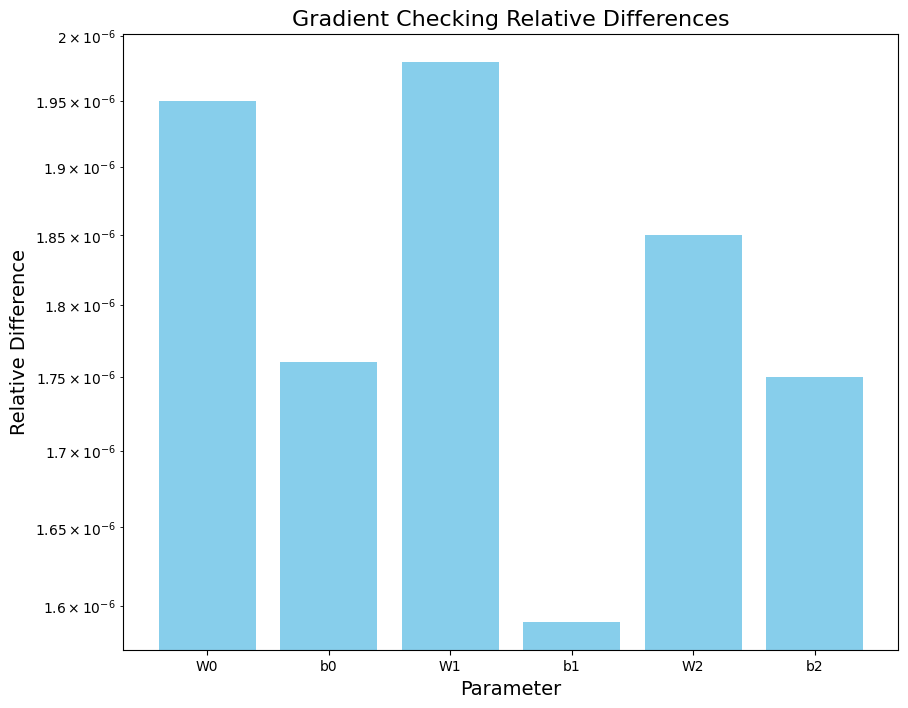


===== LEARNING CURVE PLOTS =====


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


===== TEST ACCURACY VS HIDDEN UNIT # (SINGLE LAYER) =====


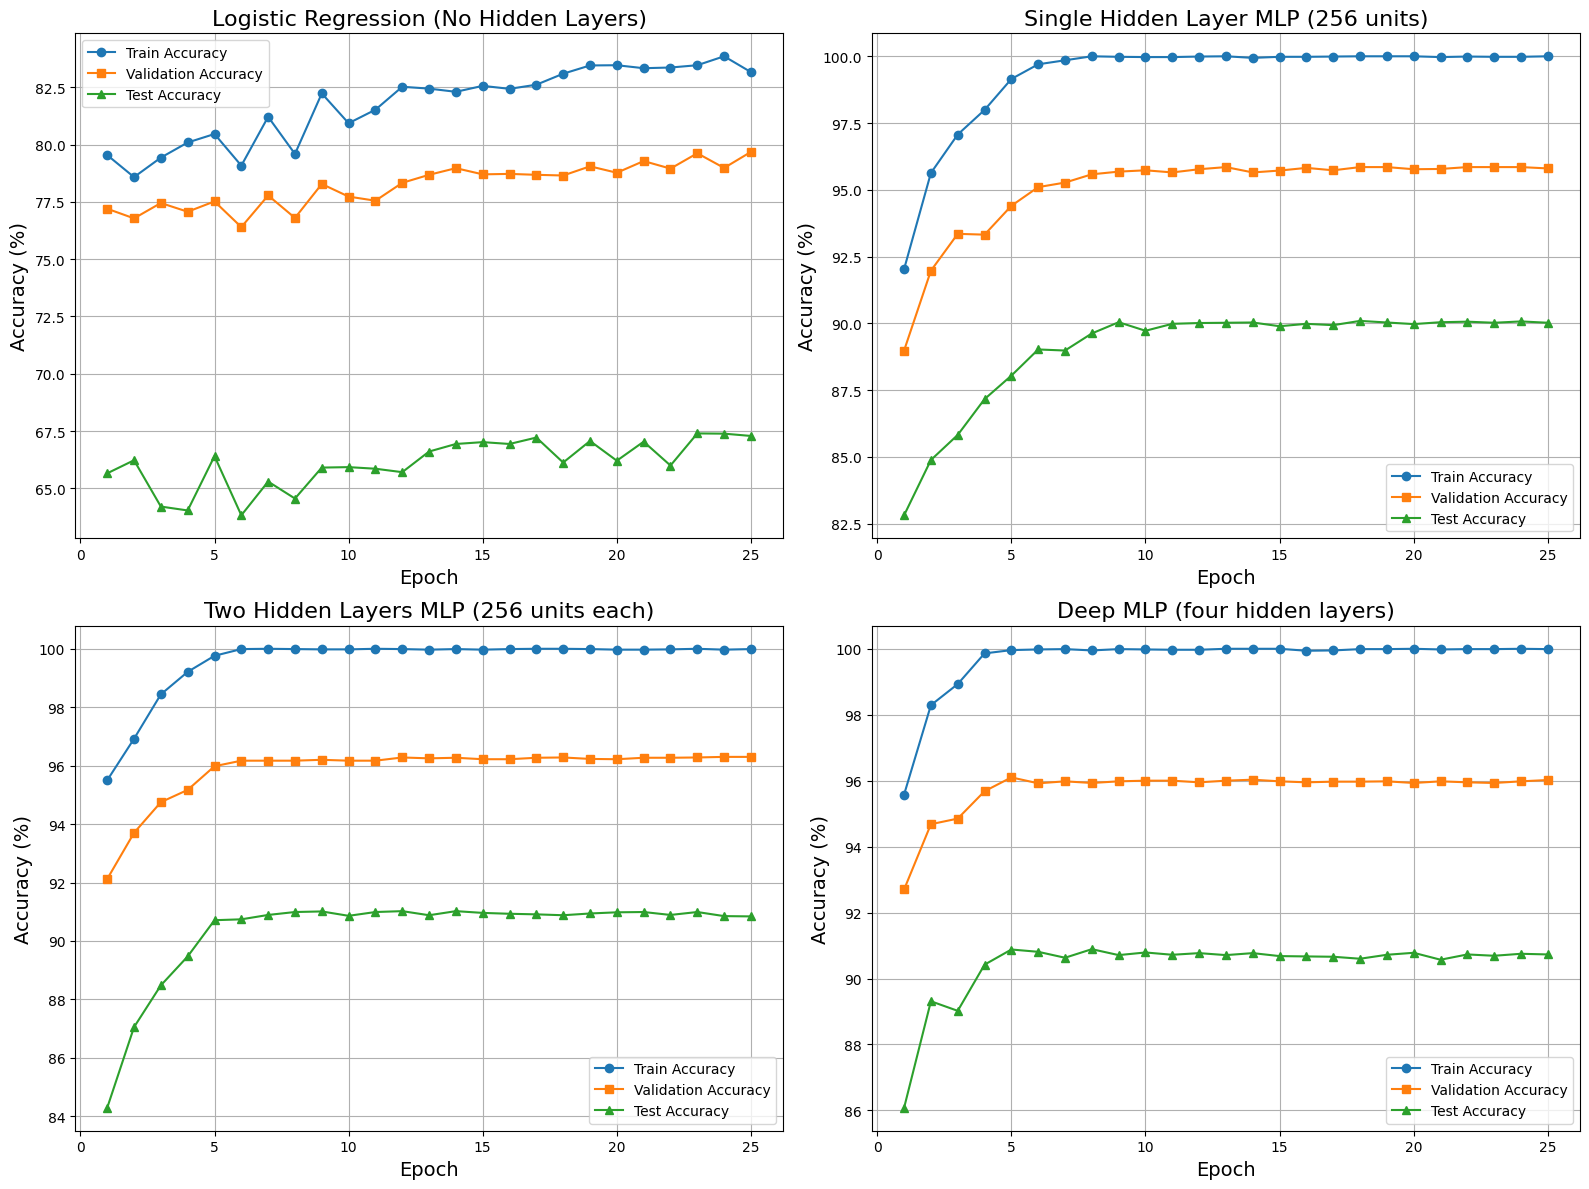

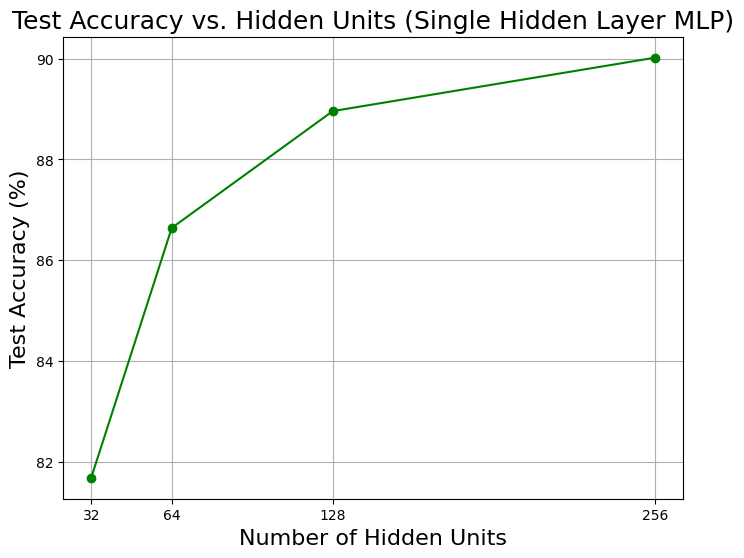


===== TEST ACCURACY VS HIDDEN UNIT # (TWO LAYER) =====


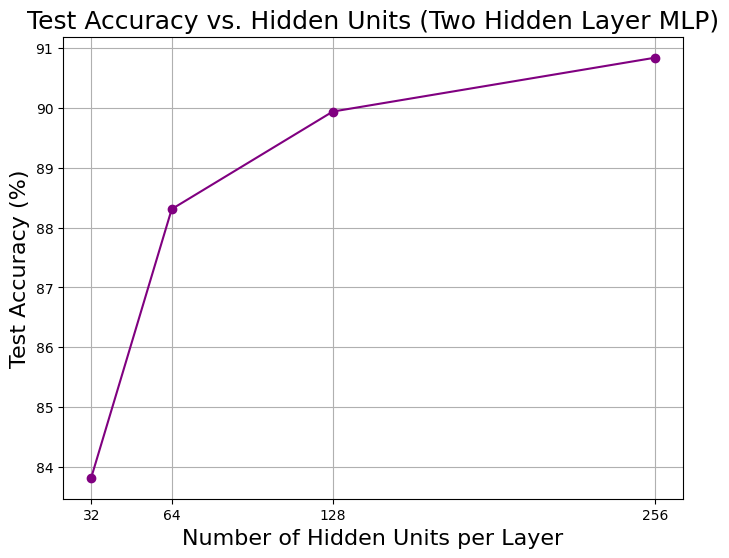


===== OVERALL COMPARISON =====


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

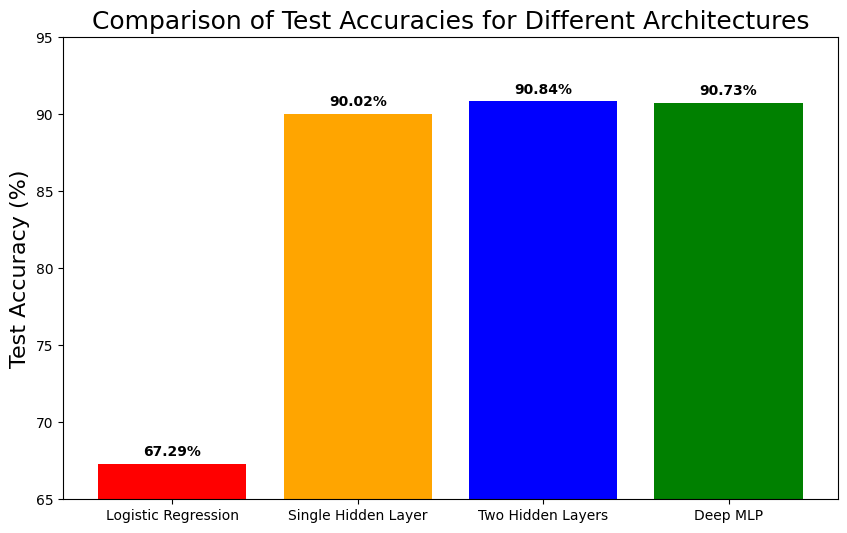

In [ ]:
#Gradient Checking Plot:
print("\n===== GRADIENT CHECKING PLOT =====")
import matplotlib.pyplot as plt

# Relative differences obtained from gradient checking:
labels = ['W0', 'b0', 'W1', 'b1', 'W2', 'b2']
diffs = [1.95e-6, 1.76e-6, 1.98e-6, 1.59e-6, 1.85e-6, 1.75e-6]

plt.figure(figsize=(10, 8))
plt.bar(labels, diffs, color='skyblue')
plt.title('Gradient Checking Relative Differences', fontsize=16)
plt.xlabel('Parameter', fontsize=14)
plt.ylabel('Relative Difference', fontsize=14)
plt.yscale('log')
plt.show()

#plt.savefig("gradient.png", dpi=300)
#from google.colab import files
#files.download("gradient.png")


#Learning Curves:
print("\n===== LEARNING CURVE PLOTS =====")
# Define the epochs
epochs = list(range(1, 26))


# Logistic Regression (No Hidden Layers)
train_acc_logistic = [79.54, 78.58, 79.43, 80.09, 80.46, 79.08, 81.21, 79.59, 82.23, 80.93,
                      81.52, 82.52, 82.44, 82.30, 82.56, 82.43, 82.61, 83.09, 83.45, 83.46,
                      83.33, 83.36, 83.46, 83.85, 83.16]
val_acc_logistic   = [77.20, 76.78, 77.45, 77.07, 77.52, 76.40, 77.78, 76.80, 78.28, 77.73,
                      77.55, 78.33, 78.68, 78.97, 78.70, 78.72, 78.68, 78.65, 79.05, 78.77,
                      79.28, 78.95, 79.62, 78.98, 79.68]
test_acc_logistic  = [65.66, 66.23, 64.21, 64.04, 66.41, 63.83, 65.30, 64.56, 65.91, 65.93,
                      65.86, 65.71, 66.61, 66.94, 67.02, 66.94, 67.22, 66.13, 67.07, 66.21,
                      67.04, 66.00, 67.40, 67.39, 67.29]

# Single Hidden Layer MLP (256 units)
train_acc_single = [92.03, 95.63, 97.07, 97.99, 99.15, 99.70, 99.85, 100.00, 99.98, 99.97,
                    99.97, 99.99, 100.00, 99.94, 99.98, 99.98, 99.99, 100.00, 100.00, 100.00,
                    99.97, 99.99, 99.98, 99.98, 100.00]

val_acc_single = [88.98, 91.97, 93.35, 93.32, 94.40, 95.10, 95.27, 95.58, 95.68, 95.73, 95.65,
                  95.77, 95.85, 95.65, 95.72, 95.82, 95.73, 95.85, 95.85, 95.77, 95.78, 95.85,
                  95.85, 95.85, 95.80]

test_acc_single  = [82.81, 84.88, 85.82, 87.16, 88.04, 89.02, 88.98, 89.62, 90.04, 89.72, 89.98,
                    90.01, 90.02, 90.03, 89.89, 89.98, 89.93, 90.09, 90.03, 89.97, 90.04, 90.06,
                    90.02, 90.07, 90.02]


# Two Hidden Layers MLP (256 units per layer)
train_acc_two = [95.50, 96.92, 98.44, 99.21, 99.76, 99.99, 100.00, 99.99, 99.98, 99.98,
                 100.00, 99.99, 99.97, 99.99, 99.97, 99.99, 100.00, 100.00, 99.99, 99.97,
                 99.97, 99.98, 100.00, 99.97, 99.99]

val_acc_two = [92.12, 93.70, 94.75, 95.17, 95.98, 96.17, 96.17, 96.17, 96.20, 96.17, 96.17,
               96.28, 96.25, 96.27, 96.22, 96.22, 96.27, 96.28, 96.23, 96.22, 96.27, 96.27,
               96.28, 96.30, 96.30]

test_acc_two  = [84.29, 87.05, 88.48, 89.47, 90.71, 90.74, 90.89, 90.99, 91.01, 90.86, 90.99, 91.02,
                 90.88, 91.02, 90.96, 90.93, 90.91, 90.88, 90.94, 90.98, 90.99, 90.89, 90.99, 90.85, 90.84]


# Deep MLP (four hidden layers: [1024, 512, 256, 128])
train_acc_deep = [95.58, 98.29, 98.93, 99.86, 99.96, 99.98, 99.99, 99.95, 99.99, 99.98,
             99.97, 99.97, 100.00, 100.00, 100.00, 99.94, 99.95, 99.99, 99.99, 100.00,
             99.98, 99.99, 99.99, 100.00, 99.99]
val_acc_deep = [92.70, 94.68, 94.85, 95.68, 96.10, 95.92, 95.98, 95.93, 95.98, 96.00,
           96.00, 95.95, 96.00, 96.03, 95.98, 95.95, 95.97, 95.97, 95.98, 95.93,
           95.98, 95.95, 95.93, 95.98, 96.02]
test_acc_deep  = [86.08, 89.31, 89.02, 90.42, 90.88, 90.81, 90.63, 90.89, 90.71, 90.79,
            90.72, 90.77, 90.71, 90.77, 90.68, 90.67, 90.66, 90.60, 90.72, 90.78,
            90.57, 90.73, 90.69, 90.75, 90.73]

# Create subplots for each model
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
axs = axs.ravel()

# Plot for Logistic Regression (No Hidden Layers)
axs[0].plot(epochs, train_acc_logistic, marker='o', label='Train Accuracy')
axs[0].plot(epochs, val_acc_logistic, marker='s', label='Validation Accuracy')
axs[0].plot(epochs, test_acc_logistic, marker='^', label='Test Accuracy')
axs[0].set_title('Logistic Regression (No Hidden Layers)', fontsize=16)
axs[0].set_xlabel('Epoch', fontsize=14)
axs[0].set_ylabel('Accuracy (%)', fontsize=14)
axs[0].legend()
axs[0].grid(True)

# Plot for Single Hidden Layer (256 units)
axs[1].plot(epochs, train_acc_single, marker='o', label='Train Accuracy')
axs[1].plot(epochs, val_acc_single, marker='s', label='Validation Accuracy')
axs[1].plot(epochs, test_acc_single, marker='^', label='Test Accuracy')
axs[1].set_title('Single Hidden Layer MLP (256 units)', fontsize=16)
axs[1].set_xlabel('Epoch', fontsize=14)
axs[1].set_ylabel('Accuracy (%)', fontsize=14)
axs[1].legend()
axs[1].grid(True)

# Plot for Two Hidden Layers (256 units per layer)
axs[2].plot(epochs, train_acc_two, marker='o', label='Train Accuracy')
axs[2].plot(epochs, val_acc_two, marker='s', label='Validation Accuracy')
axs[2].plot(epochs, test_acc_two, marker='^', label='Test Accuracy')
axs[2].set_title('Two Hidden Layers MLP (256 units each)', fontsize=16)
axs[2].set_xlabel('Epoch', fontsize=14)
axs[2].set_ylabel('Accuracy (%)', fontsize=14)
axs[2].legend()
axs[2].grid(True)

# Plot for Deep MLP (four hidden layers: [1024, 512, 256, 128])
axs[3].plot(epochs, train_acc_deep, marker='o', label='Train Accuracy')
axs[3].plot(epochs, val_acc_deep, marker='s', label='Validation Accuracy')
axs[3].plot(epochs, test_acc_deep, marker='^', label='Test Accuracy')
axs[3].set_title('Deep MLP (four hidden layers)', fontsize=16)
axs[3].set_xlabel('Epoch', fontsize=14)
axs[3].set_ylabel('Accuracy (%)', fontsize=14)
axs[3].legend()
axs[3].grid(True)

plt.tight_layout()
plt.show()

plt.savefig("learning_curves.png", dpi=300)
# from google.colab import files
# files.download("learning_curves.png")



#test accuracy vs hidden unit # (single layer):
print("\n===== TEST ACCURACY VS HIDDEN UNIT # (SINGLE LAYER) =====")
hidden_units_single = [32, 64, 128, 256]
test_acc_single = [81.68, 86.64, 88.96, 90.02]

plt.figure(figsize=(8, 6))
plt.plot(hidden_units_single, test_acc_single, marker='o', linestyle='-', color='green')
plt.title("Test Accuracy vs. Hidden Units (Single Hidden Layer MLP)", fontsize=18)
plt.xlabel("Number of Hidden Units", fontsize=16)
plt.ylabel("Test Accuracy (%)", fontsize=16)
plt.xticks(hidden_units_single)
plt.grid(True)
plt.show()

#plt.savefig("test_vs_hidden_unit_single.png", dpi=300)
#from google.colab import files
#files.download("test_vs_hidden_unit_single.png")


#test accuracy vs hidden unit # (two layer):
print("\n===== TEST ACCURACY VS HIDDEN UNIT # (TWO LAYER) =====")

hidden_units_two = [32, 64, 128, 256]
test_acc_two = [83.82, 88.31, 89.94, 90.84]

plt.figure(figsize=(8, 6))
plt.plot(hidden_units_two, test_acc_two, marker='o', linestyle='-', color='purple')
plt.title("Test Accuracy vs. Hidden Units (Two Hidden Layer MLP)", fontsize=18)
plt.xlabel("Number of Hidden Units per Layer", fontsize=16)
plt.ylabel("Test Accuracy (%)", fontsize=16)
plt.xticks(hidden_units_two)
plt.grid(True)
plt.show()

#plt.savefig("test_vs_hidden_unit_two.png", dpi=300)
#from google.colab import files
#files.download("test_vs_hidden_unit_two.png")



#overall architecture comparison:
print("\n===== OVERALL COMPARISON =====")
architectures = ['Logistic Regression', 'Single Hidden Layer', 'Two Hidden Layers', 'Deep MLP']
test_acc_arch = [67.29, 90.02, 90.84, 90.73]

plt.figure(figsize=(10, 6))
bars = plt.bar(architectures, test_acc_arch, color=['red', 'orange', 'blue', 'green'])
plt.title("Comparison of Test Accuracies for Different Architectures", fontsize=18)
plt.ylabel("Test Accuracy (%)", fontsize=16)
plt.ylim(65, 95)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.5, f"{yval:.2f}%", ha='center', fontweight='bold')
plt.show()

plt.savefig("overall.png", dpi=300)
# from google.colab import files
# files.download("overall.png")




**Task 3.2: Leaky ReLu vs Sigmoid**



===== Training MLP with Two Hidden Layers (256 units each) using LEAKY_RELU activation =====
Input dimension: 784
Hidden layer 1: 256 units with LEAKY_RELU activation
Hidden layer 2: 256 units with LEAKY_RELU activation
Output dimension: 10
Parameters: 269,322
Epoch 1/25 | LR: 0.500000 | Loss: 0.3807 | Train Acc: 95.92% | Val Acc: 92.93% | Test Acc: 84.91%
Epoch 2/25 | LR: 0.475000 | Loss: 0.1393 | Train Acc: 97.27% | Val Acc: 94.30% | Test Acc: 87.38%
Epoch 3/25 | LR: 0.451250 | Loss: 0.0783 | Train Acc: 98.64% | Val Acc: 94.98% | Test Acc: 88.76%
Epoch 4/25 | LR: 0.428687 | Loss: 0.0385 | Train Acc: 99.39% | Val Acc: 95.30% | Test Acc: 89.49%
Epoch 5/25 | LR: 0.407253 | Loss: 0.0179 | Train Acc: 99.79% | Val Acc: 95.87% | Test Acc: 90.09%
Epoch 6/25 | LR: 0.386890 | Loss: 0.0065 | Train Acc: 99.96% | Val Acc: 95.93% | Test Acc: 90.70%
Epoch 7/25 | LR: 0.367546 | Loss: 0.0027 | Train Acc: 100.00% | Val Acc: 96.22% | Test Acc: 90.71%
Epoch 8/25 | LR: 0.349169 | Loss: 0.0019 | Train A

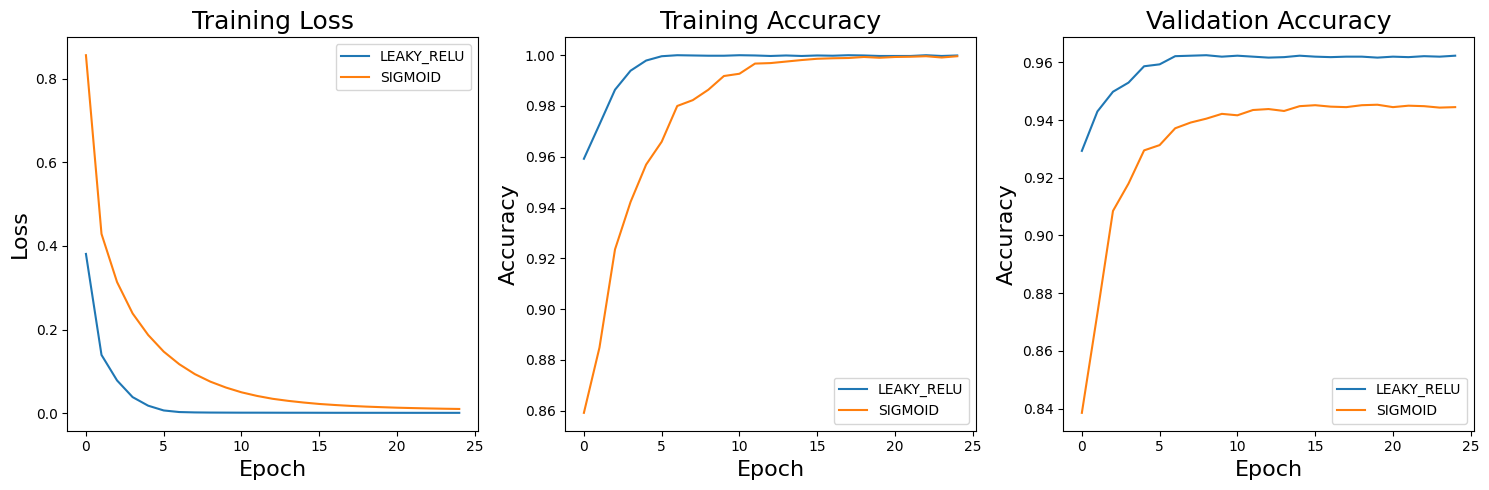


===== ANALYSIS =====
The LEAKY RELU activation function performed better with a test accuracy of 90.80% compared to 88.53% for the other activation function.


In [ ]:
# Activation functions for comparison
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

def leaky_relu(x, alpha=0.01):
    return np.maximum(alpha * x, x)

def leaky_relu_derivative(x, alpha=0.01):
    return np.where(x > 0, 1, alpha)

# Create a new class that extends the existing TwoHiddenLayerMLP
class ActivationMLP(TwoHiddenLayerMLP):
    def __init__(self, hidden_units=64, activation='leaky_relu', random_seed=42):
        """MLP model with two hidden layers and flexible activation function"""
        np.random.seed(random_seed)

        self.input_dim = 784
        self.hidden_dim = hidden_units
        self.output_dim = 10
        self.activation = activation

        # Set activation function
        if activation == 'sigmoid':
            self.activation_fn = sigmoid
            self.activation_derivative = sigmoid_derivative
            # Xavier initialization for sigmoid
            scale1 = np.sqrt(1.0 / self.input_dim)
            scale2 = np.sqrt(1.0 / self.hidden_dim)
            scale3 = np.sqrt(1.0 / self.hidden_dim)
        elif activation == 'leaky_relu':
            self.activation_fn = lambda x: leaky_relu(x)
            self.activation_derivative = lambda x: leaky_relu_derivative(x)
            # He initialization for Leaky ReLU
            scale1 = np.sqrt(2.0 / self.input_dim)
            scale2 = np.sqrt(2.0 / self.hidden_dim)
            scale3 = np.sqrt(1.0 / self.hidden_dim)

        # Layer 1
        self.W1 = scale1 * np.random.randn(self.input_dim, self.hidden_dim).astype(np.float32)
        self.b1 = np.zeros((1, self.hidden_dim), dtype=np.float32)

        # Layer 2
        self.W2 = scale2 * np.random.randn(self.hidden_dim, self.hidden_dim).astype(np.float32)
        self.b2 = np.zeros((1, self.hidden_dim), dtype=np.float32)

        # Output layer
        self.W3 = scale3 * np.random.randn(self.hidden_dim, self.output_dim).astype(np.float32)
        self.b3 = np.zeros((1, self.output_dim), dtype=np.float32)

    def forward(self, X):
        """Forward pass through the network"""
        # Hidden layer 1
        Z1 = X @ self.W1 + self.b1
        A1 = self.activation_fn(Z1)

        # Hidden layer 2
        Z2 = A1 @ self.W2 + self.b2
        A2 = self.activation_fn(Z2)

        # Output layer
        Z3 = A2 @ self.W3 + self.b3

        # Store activations for backpropagation
        self.cache = {'X': X, 'Z1': Z1, 'A1': A1, 'Z2': Z2, 'A2': A2}

        return Z3

    def compute_loss_and_grads(self, X, y_onehot):
        """Computes cross-entropy loss and gradients"""
        batch_size = X.shape[0]

        # Forward pass
        logits = self.forward(X)
        probs = softmax(logits)

        # Cross-entropy loss
        loss = -np.sum(y_onehot * np.log(probs + 1e-8)) / batch_size

        # Backpropagation
        # Output layer gradients
        dZ3 = (probs - y_onehot) / batch_size
        dW3 = self.cache['A2'].T @ dZ3
        db3 = np.sum(dZ3, axis=0, keepdims=True)

        # Hidden layer 2 gradients
        dA2 = dZ3 @ self.W3.T
        dZ2 = dA2 * self.activation_derivative(self.cache['Z2'])
        dW2 = self.cache['A1'].T @ dZ2
        db2 = np.sum(dZ2, axis=0, keepdims=True)

        # Hidden layer 1 gradients
        dA1 = dZ2 @ self.W2.T
        dZ1 = dA1 * self.activation_derivative(self.cache['Z1'])
        dW1 = self.cache['X'].T @ dZ1
        db1 = np.sum(dZ1, axis=0, keepdims=True)

        return loss, {'dW1': dW1, 'db1': db1, 'dW2': dW2, 'db2': db2, 'dW3': dW3, 'db3': db3}

# Experiment code
X_train, y_train, X_val, y_val, X_test, y_test = get_preprocessed_data(val_size=0.1, random_seed=42)


best_hidden_units = 256

# Train models with different activation functions
activation_functions = ['leaky_relu', 'sigmoid']
results = {}

for activation in activation_functions:
    print(f"\n\n===== Training MLP with Two Hidden Layers ({best_hidden_units} units each) using {activation.upper()} activation =====")
    print(f"Input dimension: 784")
    print(f"Hidden layer 1: {best_hidden_units} units with {activation.upper()} activation")
    print(f"Hidden layer 2: {best_hidden_units} units with {activation.upper()} activation")
    print(f"Output dimension: 10")

    # Calculate parameter count
    params = (784 * best_hidden_units + best_hidden_units) + (best_hidden_units * best_hidden_units + best_hidden_units) + (best_hidden_units * 10 + 10)
    print(f"Parameters: {params:,}")

    # Initialize and train the model
    model = ActivationMLP(hidden_units=best_hidden_units, activation=activation, random_seed=42)

    # Train the model
    history = model.fit(
        X_train,
        y_train,
        X_val=X_val,
        y_val=y_val,
        X_test=X_test,
        y_test=y_test,
        epochs=25,
        batch_size=128,
        lr=0.5,
        lr_decay=0.95,
        print_every=1
    )

    # Evaluate on test set
    y_pred_test = model.predict(X_test)
    test_acc = evaluate_acc(y_test, y_pred_test)

    # Get final accuracies
    final_train_acc = history['train_accs'][-1]
    final_val_acc = history['val_accs'][-1]

    # Print final results
    print("\n===== FINAL RESULTS =====")
    print(f"Activation: {activation.upper()}")
    print(f"Training accuracy:   {final_train_acc * 100:.2f}%")
    print(f"Validation accuracy: {final_val_acc * 100:.2f}%")
    print(f"Test accuracy:       {test_acc * 100:.2f}%")

    # Save the results
    results[activation] = {
        'params': params,
        'train_acc': final_train_acc,
        'val_acc': final_val_acc,
        'test_acc': test_acc,
        'train_losses': history['train_losses'],
        'train_accs': history['train_accs'],
        'val_accs': history['val_accs']
    }

# Compare results
print("\n\n===== COMPARISON OF ACTIVATION FUNCTIONS =====")
print(f"Hidden units: {best_hidden_units} per layer")
print("\nTest Accuracies:")
for activation in activation_functions:
    print(f"{activation.upper()}: {results[activation]['test_acc'] * 100:.2f}%")

# Plot learning curves for both models
plt.figure(figsize=(15, 5))

# Training loss
plt.subplot(1, 3, 1)
for activation in activation_functions:
    plt.plot(results[activation]['train_losses'], label=activation.upper())
plt.title('Training Loss', fontsize=18)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend()

# Training accuracy
plt.subplot(1, 3, 2)
for activation in activation_functions:
    plt.plot(results[activation]['train_accs'], label=activation.upper())
plt.title('Training Accuracy', fontsize=18)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend()

# Validation accuracy
plt.subplot(1, 3, 3)
for activation in activation_functions:
    plt.plot(results[activation]['val_accs'], label=activation.upper())
plt.title('Validation Accuracy', fontsize=18)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend()

plt.tight_layout()
plt.show()

#plt.savefig("activation_fn.png", dpi=300)
#from google.colab import files
#files.download("activation_fn.png")

# Add commentary on the results
print("\n===== ANALYSIS =====")
sigmoid_acc = results['sigmoid']['test_acc'] * 100
leaky_relu_acc = results['leaky_relu']['test_acc'] * 100
better = "SIGMOID" if sigmoid_acc > leaky_relu_acc else "LEAKY RELU"

print(f"The {better} activation function performed better with a test accuracy of " +
      f"{max(sigmoid_acc, leaky_relu_acc):.2f}% compared to " +
      f"{min(sigmoid_acc, leaky_relu_acc):.2f}% for the other activation function.")

**Task3.3: L2 Regularization**



===== Training MLP with Two Hidden Layers (256 units each) and L2 regularization (λ=0.0) =====
Epoch 1/25 | LR: 0.500000 | Loss: 0.3831 | Train Acc: 95.50% | Val Acc: 92.12% | Test Acc: 84.29%
Epoch 2/25 | LR: 0.475000 | Loss: 0.1363 | Train Acc: 96.92% | Val Acc: 93.70% | Test Acc: 87.05%
Epoch 3/25 | LR: 0.451250 | Loss: 0.0751 | Train Acc: 98.44% | Val Acc: 94.75% | Test Acc: 88.48%
Epoch 4/25 | LR: 0.428687 | Loss: 0.0391 | Train Acc: 99.21% | Val Acc: 95.17% | Test Acc: 89.47%
Epoch 5/25 | LR: 0.407253 | Loss: 0.0187 | Train Acc: 99.76% | Val Acc: 95.98% | Test Acc: 90.71%
Epoch 6/25 | LR: 0.386890 | Loss: 0.0067 | Train Acc: 99.99% | Val Acc: 96.17% | Test Acc: 90.74%
Epoch 7/25 | LR: 0.367546 | Loss: 0.0026 | Train Acc: 100.00% | Val Acc: 96.17% | Test Acc: 90.89%
Epoch 8/25 | LR: 0.349169 | Loss: 0.0018 | Train Acc: 99.99% | Val Acc: 96.17% | Test Acc: 90.99%
Epoch 9/25 | LR: 0.331710 | Loss: 0.0015 | Train Acc: 99.98% | Val Acc: 96.20% | Test Acc: 91.01%
Epoch 10/25 | LR: 0.

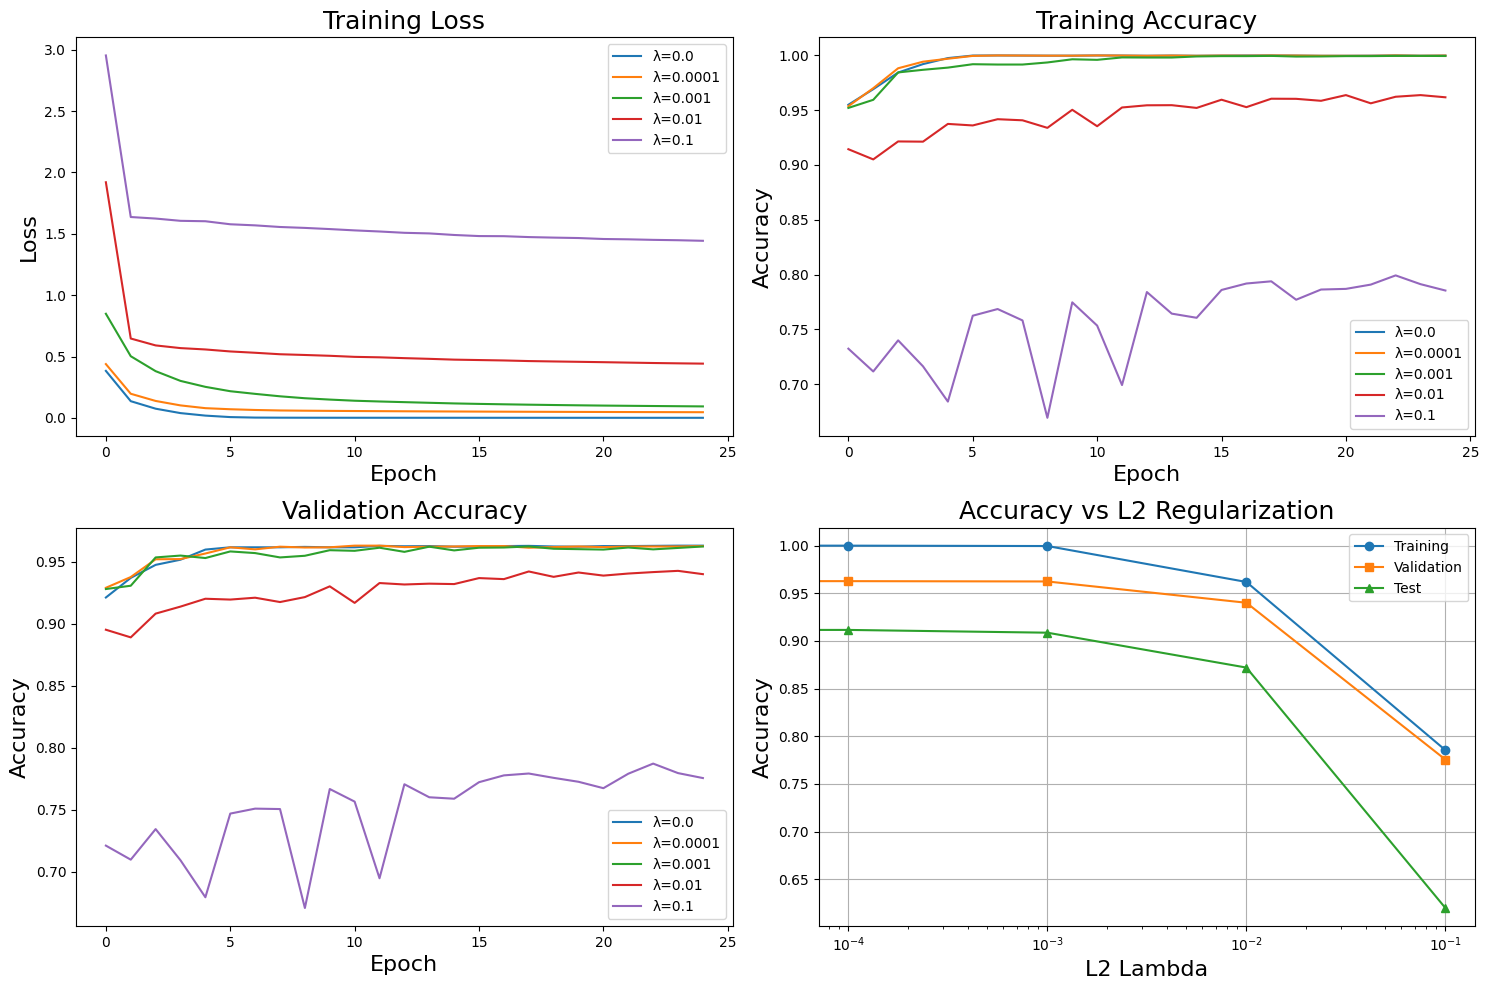

In [ ]:
# L2 Regularized MLP implementation
class TwoHiddenLayerMLP_L2(TwoHiddenLayerMLP):
    def __init__(self, hidden_units=64, l2_lambda=0.0, random_seed=42):
        """MLP model with two hidden layers and L2 regularization"""
        # Call the parent constructor to set up the network architecture
        super().__init__(hidden_units=hidden_units, random_seed=random_seed)

        # L2 regularization parameter
        self.l2_lambda = l2_lambda

    def compute_loss_and_grads(self, X, y_onehot):
        """Computes cross-entropy loss and gradients with L2 regularization"""
        batch_size = X.shape[0]

        # Forward pass
        logits = self.forward(X)
        probs = softmax(logits)

        # Cross-entropy loss
        data_loss = -np.sum(y_onehot * np.log(probs + 1e-8)) / batch_size

        # L2 regularization loss
        reg_loss = 0.5 * self.l2_lambda * (
            np.sum(self.W1 * self.W1) +
            np.sum(self.W2 * self.W2) +
            np.sum(self.W3 * self.W3)
        )

        # Total loss
        total_loss = data_loss + reg_loss

        # Backpropagation
        # Output layer gradients
        dZ3 = (probs - y_onehot) / batch_size
        dW3 = self.cache['A2'].T @ dZ3 + self.l2_lambda * self.W3  # Add L2 gradient
        db3 = np.sum(dZ3, axis=0, keepdims=True)

        # Hidden layer 2 gradients
        dA2 = dZ3 @ self.W3.T
        dZ2 = dA2 * relu_derivative(self.cache['Z2'])
        dW2 = self.cache['A1'].T @ dZ2 + self.l2_lambda * self.W2  # Add L2 gradient
        db2 = np.sum(dZ2, axis=0, keepdims=True)

        # Hidden layer 1 gradients
        dA1 = dZ2 @ self.W2.T
        dZ1 = dA1 * relu_derivative(self.cache['Z1'])
        dW1 = self.cache['X'].T @ dZ1 + self.l2_lambda * self.W1  # Add L2 gradient
        db1 = np.sum(dZ1, axis=0, keepdims=True)

        return total_loss, {'dW1': dW1, 'db1': db1, 'dW2': dW2, 'db2': db2, 'dW3': dW3, 'db3': db3}

# Experiment code
X_train, y_train, X_val, y_val, X_test, y_test = get_preprocessed_data(val_size=0.1, random_seed=42)


best_hidden_units = 256


# Try different L2 regularization values
l2_lambda_values = [0.0, 0.0001, 0.001, 0.01, 0.1]
results = []

for l2_lambda in l2_lambda_values:
    print(f"\n\n===== Training MLP with Two Hidden Layers ({best_hidden_units} units each) and L2 regularization (λ={l2_lambda}) =====")

    # Initialize and train the model
    model = TwoHiddenLayerMLP_L2(hidden_units=best_hidden_units, l2_lambda=l2_lambda, random_seed=42)

    # Train the model
    history = model.fit(
        X_train,
        y_train,
        X_val=X_val,
        y_val=y_val,
        X_test=X_test,
        y_test=y_test,
        epochs=25,
        batch_size=128,
        lr=0.5,
        lr_decay=0.95,
        print_every=1
    )

    # Evaluate on test set
    y_pred_test = model.predict(X_test)
    test_acc = evaluate_acc(y_test, y_pred_test)

    # Get final accuracies
    final_train_acc = history['train_accs'][-1]
    final_val_acc = history['val_accs'][-1]

    # Print final results
    print("\n===== FINAL RESULTS =====")
    print(f"L2 Lambda: {l2_lambda}")
    print(f"Training accuracy:   {final_train_acc * 100:.2f}%")
    print(f"Validation accuracy: {final_val_acc * 100:.2f}%")
    print(f"Test accuracy:       {test_acc * 100:.2f}%")

    # Save the results
    results.append({
        'l2_lambda': l2_lambda,
        'train_acc': final_train_acc,
        'val_acc': final_val_acc,
        'test_acc': test_acc,
        'train_losses': history['train_losses'],
        'train_accs': history['train_accs'],
        'val_accs': history['val_accs']
    })

# Find the best model based on validation accuracy
best_model_idx = np.argmax([r['val_acc'] for r in results])
best_model = results[best_model_idx]

print("\n\n===== BEST MODEL WITH L2 REGULARIZATION =====")
print(f"L2 Lambda: {best_model['l2_lambda']}")
print(f"Hidden units: {best_hidden_units} per layer")
print(f"Training accuracy:   {best_model['train_acc'] * 100:.2f}%")
print(f"Validation accuracy: {best_model['val_acc'] * 100:.2f}%")
print(f"Test accuracy:       {best_model['test_acc'] * 100:.2f}%")

# Plot learning curves for all models
plt.figure(figsize=(15, 10))

# Training loss
plt.subplot(2, 2, 1)
for res in results:
    plt.plot(res['train_losses'], label=f"λ={res['l2_lambda']}")
plt.title('Training Loss', fontsize=18)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend()

# Training accuracy
plt.subplot(2, 2, 2)
for res in results:
    plt.plot(res['train_accs'], label=f"λ={res['l2_lambda']}")
plt.title('Training Accuracy', fontsize=18)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend()

# Validation accuracy
plt.subplot(2, 2, 3)
for res in results:
    plt.plot(res['val_accs'], label=f"λ={res['l2_lambda']}")
plt.title('Validation Accuracy', fontsize=18)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend()

# Test accuracy vs lambda
plt.subplot(2, 2, 4)
lambdas = [r['l2_lambda'] for r in results]
train_accs = [r['train_acc'] for r in results]
val_accs = [r['val_acc'] for r in results]
test_accs = [r['test_acc'] for r in results]

plt.semilogx(lambdas, train_accs, 'o-', label='Training')
plt.semilogx(lambdas, val_accs, 's-', label='Validation')
plt.semilogx(lambdas, test_accs, '^-', label='Test')
plt.title('Accuracy vs L2 Regularization', fontsize=18)
plt.xlabel('L2 Lambda', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()





**Task3.4: CNN**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class KMNISTConvNet(nn.Module):
    def __init__(self, fc_hidden_units=64):
        """
        CNN for KMNIST with 3 convolutional layers and 2 fully connected layers.
        Args:
            fc_hidden_units: Number of hidden units in the first fully connected layer
        """
        super(KMNISTConvNet, self).__init__()

        # Convolutional layers
        # Input: 1x28x28
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)  # Output: 32x28x28
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # Output: 64x14x14 (after pooling)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)  # Output: 128x7x7 (after pooling)

        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 7 * 7, fc_hidden_units)
        self.fc2 = nn.Linear(fc_hidden_units, 10)

        # Dropout for regularization
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # Input shape: (batch_size, 1, 28, 28)

        # First conv block
        x = F.relu(self.conv1(x))  # (batch_size, 32, 28, 28)
        x = self.pool(x)  # (batch_size, 32, 14, 14)

        # Second conv block
        x = F.relu(self.conv2(x))  # (batch_size, 64, 14, 14)
        x = self.pool(x)  # (batch_size, 64, 7, 7)

        # Third conv block
        x = F.relu(self.conv3(x))  # (batch_size, 128, 7, 7)

        # Flatten
        x = x.view(x.size(0), -1)  # (batch_size, 128*7*7)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

def train_one_epoch(model, train_loader, criterion, optimizer, device):
    """Train the model for one epoch."""
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    train_acc = correct / total
    train_loss = train_loss / len(train_loader)

    return train_loss, train_acc

def evaluate(model, loader, criterion, device):
    """Evaluate the model on a given dataset."""
    model.eval()
    eval_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(loader):
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            eval_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    eval_acc = correct / total
    eval_loss = eval_loss / len(loader)

    return eval_loss, eval_acc

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler,
                num_epochs, device, print_every=1):
    """Train the model for multiple epochs."""
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    test_accs = []

    for epoch in range(num_epochs):
        # Train one epoch
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Evaluate on validation set
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        #evaluate on test set each epoch
        _, test_acc = evaluate(model, test_loader, criterion, device)
        test_accs.append(test_acc)

        # Step the learning rate scheduler
        if scheduler:
            scheduler.step()

        if epoch % print_every == 0:
            print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}% | "
                  f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%"
                  f"Test Acc: {test_acc*100:.2f}%")


    return {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'val_losses': val_losses,
        'val_accs': val_accs,
        'test_accs': test_accs
    }

def prepare_loaders(X_train, y_train, X_val, y_val, X_test, y_test, batch_size=128):
    """Prepare PyTorch data loaders."""
    # Reshape data for CNNs [N, C, H, W]
    X_train = X_train.reshape(-1, 1, 28, 28)
    X_val = X_val.reshape(-1, 1, 28, 28)
    X_test = X_test.reshape(-1, 1, 28, 28)

    # Convert numpy arrays to PyTorch tensors
    X_train_tensor = torch.from_numpy(X_train).float()
    y_train_tensor = torch.from_numpy(y_train).long()

    X_val_tensor = torch.from_numpy(X_val).float()
    y_val_tensor = torch.from_numpy(y_val).long()

    X_test_tensor = torch.from_numpy(X_test).float()
    y_test_tensor = torch.from_numpy(y_test).long()

    # Create datasets
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

if __name__ == "__main__":
    # Load and preprocess data
    X_train, y_train, X_val, y_val, X_test, y_test = get_preprocessed_data(val_size=0.1, random_seed=42)

    # Prepare data loaders
    train_loader, val_loader, test_loader = prepare_loaders(
        X_train, y_train, X_val, y_val, X_test, y_test, batch_size=128
    )

    # Model hyperparameters
    fc_hidden_units_options = [32, 64, 128, 256]
    num_epochs = 15
    learning_rate = 0.001
    batch_size = 128

    results = []

    # Try different hidden units for the fully connected layer
    for fc_hidden_units in fc_hidden_units_options:
        print(f"\n\n===== Training CNN with FC Hidden Units: {fc_hidden_units} =====")

        # Calculate parameter count
        conv1_params = 32 * (3 * 3 * 1 + 1)
        conv2_params = 64 * (3 * 3 * 32 + 1)
        conv3_params = 128 * (3 * 3 * 64 + 1)
        fc1_params = (128 * 7 * 7) * fc_hidden_units + fc_hidden_units
        fc2_params = fc_hidden_units * 10 + 10
        total_params = conv1_params + conv2_params + conv3_params + fc1_params + fc2_params

        print(f"Total parameters: {total_params:,}")

        # Initialize the model
        model = KMNISTConvNet(fc_hidden_units=fc_hidden_units).to(device)

        # Loss and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        # Learning rate scheduler
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

        # Train the model
        history = train_model(
            model,
            train_loader,
            val_loader,
            criterion,
            optimizer,
            scheduler,
            num_epochs,
            device,
            print_every=1
        )

        # Evaluate on test set
        test_loss, test_acc = evaluate(model, test_loader, criterion, device)

        # Get final accuracies
        final_train_acc = history['train_accs'][-1]
        final_val_acc = history['val_accs'][-1]

        # Print final results
        print("\n===== FINAL RESULTS =====")
        print(f"FC Hidden Units: {fc_hidden_units}")
        print(f"Training accuracy:   {final_train_acc * 100:.2f}%")
        print(f"Validation accuracy: {final_val_acc * 100:.2f}%")
        print(f"Test accuracy:       {test_acc * 100:.2f}%")

        # Save the results
        results.append({
            'fc_hidden_units': fc_hidden_units,
            'params': total_params,
            'train_acc': final_train_acc,
            'val_acc': final_val_acc,
            'test_acc': test_acc,
            'train_losses': history['train_losses'],
            'train_accs': history['train_accs'],
            'val_losses': history['val_losses'],
            'val_accs': history['val_accs'],
            'test_accs': history['test_accs'],
        })

    # Find the best model based on validation accuracy
    best_model_idx = np.argmax([r['val_acc'] for r in results])
    best_model = results[best_model_idx]

    print("\n\n===== BEST CNN MODEL =====")
    print(f"FC Hidden Units: {best_model['fc_hidden_units']}")
    print(f"Parameters: {best_model['params']:,}")
    print(f"Training accuracy:   {best_model['train_acc'] * 100:.2f}%")
    print(f"Validation accuracy: {best_model['val_acc'] * 100:.2f}%")
    print(f"Test accuracy:       {best_model['test_acc'] * 100:.2f}%")



    # Plot learning curves for all models
    plt.figure(figsize=(15, 10))

    # Training loss
    plt.subplot(2, 2, 1)
    for res in results:
        plt.plot(res['train_losses'], label=f"Hidden Units: {res['fc_hidden_units']}")
    plt.title('Training Loss', fontsize = 18)
    plt.xlabel('Epoch', fontsize = 16)
    plt.ylabel('Loss', fontsize = 16)
    plt.legend()

    # Validation loss
    plt.subplot(2, 2, 2)
    for res in results:
        plt.plot(res['val_losses'], label=f"Hidden Units: {res['fc_hidden_units']}")
    plt.title('Validation Loss', fontsize = 18)
    plt.xlabel('Epoch', fontsize = 16)
    plt.ylabel('Loss', fontsize = 16)
    plt.legend()

    # Training accuracy
    plt.subplot(2, 2, 3)
    for res in results:
        plt.plot(res['train_accs'], label=f"Hidden Units: {res['fc_hidden_units']}")
    plt.title('Training Accuracy', fontsize = 18)
    plt.xlabel('Epoch', fontsize = 16)
    plt.ylabel('Accuracy', fontsize = 16)
    plt.legend()

    # Validation accuracy
    plt.subplot(2, 2, 4)
    for res in results:
        plt.plot(res['val_accs'], label=f"Hidden Units: {res['fc_hidden_units']}")
    plt.title('Validation Accuracy', fontsize = 18)
    plt.xlabel('Epoch', fontsize = 16)
    plt.ylabel('Accuracy', fontsize = 16)
    plt.legend()

    plt.tight_layout()
    plt.show()

    #plt.savefig("CNN.png", dpi=300)
    #from google.colab import files
    #files.download("CNN.png")

    #plot learning curves 2
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    axs = axs.ravel()
    epochs_arr = np.arange(1, num_epochs+1)

    for i, res in enumerate(results):
        axs[i].plot(epochs_arr, res['train_accs'], marker='o', label='Train Acc')
        axs[i].plot(epochs_arr, res['val_accs'], marker='s', label='Val Acc')
        axs[i].plot(epochs_arr, res['test_accs'], marker='^', label='Test Acc')
        axs[i].set_title(f"FC Units: {res['fc_hidden_units']}\nFinal Test Acc: {res['test_acc']*100:.2f}%", fontsize=18)
        axs[i].set_xlabel('Epoch', fontsize=16)
        axs[i].set_ylabel('Accuracy (%)', fontsize=16)
        axs[i].legend(loc='lower right', fontsize=16)
        axs[i].grid(True)

    plt.tight_layout()
    plt.show()

    plt.savefig("CNN2.png", dpi=300)
#     from google.colab import files
#     files.download("CNN2.png")


    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)
    for res in results:
        plt.plot(epochs_arr, res['train_losses'], label=f"Hidden Units: {res['fc_hidden_units']}")
    plt.title('Training Loss vs. Epoch', fontsize=18)
    plt.xlabel('Epoch', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 1, 2)
    for res in results:
        plt.plot(epochs_arr, res['val_losses'], label=f"Hidden Units: {res['fc_hidden_units']}")
    plt.title('Validation Loss vs. Epoch', fontsize=18)
    plt.xlabel('Epoch', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    plt.savefig("CNN3.png", dpi=300)
#     from google.colab import files
#     files.download("CNN3.png")




Using device: cpu


===== Training CNN with FC Hidden Units: 32 =====
Total parameters: 293,738
Epoch 1/15 | Train Loss: 0.4877 | Train Acc: 84.42% | Val Loss: 0.1303 | Val Acc: 96.15%Test Acc: 90.31%
Epoch 2/15 | Train Loss: 0.1589 | Train Acc: 95.13% | Val Loss: 0.0999 | Val Acc: 97.28%Test Acc: 92.69%
Epoch 3/15 | Train Loss: 0.1039 | Train Acc: 96.86% | Val Loss: 0.0777 | Val Acc: 97.80%Test Acc: 94.08%
Epoch 4/15 | Train Loss: 0.0741 | Train Acc: 97.59% | Val Loss: 0.0754 | Val Acc: 98.13%Test Acc: 94.43%
Epoch 5/15 | Train Loss: 0.0584 | Train Acc: 98.06% | Val Loss: 0.0783 | Val Acc: 98.12%Test Acc: 95.01%
Epoch 6/15 | Train Loss: 0.0354 | Train Acc: 98.85% | Val Loss: 0.0675 | Val Acc: 98.32%Test Acc: 95.44%
Epoch 7/15 | Train Loss: 0.0275 | Train Acc: 99.08% | Val Loss: 0.0689 | Val Acc: 98.42%Test Acc: 95.60%
Epoch 8/15 | Train Loss: 0.0242 | Train Acc: 99.13% | Val Loss: 0.0745 | Val Acc: 98.38%Test Acc: 95.61%
Epoch 9/15 | Train Loss: 0.0230 | Train Acc: 99.22% | Val Loss: 

PLOT:

In [ ]:
import matplotlib.pyplot as plt

# Define epoch numbers for 15 epochs
epochs = list(range(1, 16))

# Data for FC Units: 32
train_loss_32 = [0.4888, 0.1660, 0.1158, 0.0855, 0.0649, 0.0377, 0.0309, 0.0295, 0.0254, 0.0247, 0.0236, 0.0220, 0.0218, 0.0216, 0.0210]
train_acc_32  = [84.25, 94.82, 96.34, 97.24, 97.86, 98.74, 98.94, 99.04, 99.14, 99.14, 99.21, 99.23, 99.23, 99.25, 99.29]
val_loss_32   = [0.1446, 0.0976, 0.0939, 0.0748, 0.0745, 0.0692, 0.0723, 0.0708, 0.0750, 0.0733, 0.0736, 0.0744, 0.0749, 0.0753, 0.0754]
val_acc_32    = [95.85, 97.30, 97.40, 97.97, 98.28, 98.53, 98.55, 98.58, 98.55, 98.52, 98.55, 98.58, 98.58, 98.62, 98.62]
final_test_32 = 95.81

# Data for FC Units: 64
train_loss_64 = [0.3838, 0.1136, 0.0743, 0.0485, 0.0395, 0.0201, 0.0148, 0.0124, 0.0109, 0.0092, 0.0084, 0.0079, 0.0082, 0.0083, 0.0074]
train_acc_64  = [87.87, 96.59, 97.73, 98.39, 98.73, 99.36, 99.50, 99.65, 99.61, 99.72, 99.74, 99.77, 99.74, 99.75, 99.77]
val_loss_64   = [0.1173, 0.0886, 0.0694, 0.0709, 0.0773, 0.0687, 0.0681, 0.0703, 0.0710, 0.0731, 0.0734, 0.0737, 0.0740, 0.0740, 0.0744]
val_acc_64    = [96.50, 97.17, 98.05, 98.10, 97.97, 98.48, 98.63, 98.70, 98.62, 98.73, 98.75, 98.77, 98.73, 98.73, 98.67]
final_test_64 = 96.33

# Data for FC Units: 128
train_loss_128 = [0.3084, 0.0866, 0.0498, 0.0352, 0.0244, 0.0104, 0.0067, 0.0050, 0.0042, 0.0037, 0.0032, 0.0032, 0.0028, 0.0029, 0.0030]
train_acc_128  = [90.25, 97.27, 98.44, 98.84, 99.25, 99.69, 99.78, 99.86, 99.90, 99.89, 99.90, 99.91, 99.92, 99.92, 99.92]
val_loss_128   = [0.1120, 0.0770, 0.0719, 0.0624, 0.0738, 0.0654, 0.0668, 0.0688, 0.0724, 0.0769, 0.0759, 0.0752, 0.0753, 0.0754, 0.0758]
val_acc_128    = [96.88, 97.82, 98.10, 98.45, 98.10, 98.55, 98.53, 98.57, 98.60, 98.57, 98.63, 98.65, 98.63, 98.62, 98.62]
final_test_128 = 96.56

# Data for FC Units: 256
train_loss_256 = [0.2609, 0.0669, 0.0373, 0.0271, 0.0182, 0.0064, 0.0031, 0.0027, 0.0022, 0.0021, 0.0018, 0.0014, 0.0015, 0.0013, 0.0012]
train_acc_256  = [91.89, 97.95, 98.81, 99.13, 99.40, 99.79, 99.92, 99.94, 99.93, 99.94, 99.95, 99.97, 99.97, 99.96, 99.97]
val_loss_256   = [0.0944, 0.0704, 0.0620, 0.0692, 0.0698, 0.0645, 0.0678, 0.0710, 0.0710, 0.0755, 0.0740, 0.0735, 0.0740, 0.0744, 0.0749]
val_acc_256    = [97.37, 98.10, 98.37, 98.23, 98.45, 98.70, 98.80, 98.73, 98.73, 98.72, 98.77, 98.72, 98.78, 98.78, 98.80]
final_test_256 = 96.68

# Create a 2x2 grid of subplots for the learning curves
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.ravel()

# For each subplot, plot the training loss (as a secondary axis) and the accuracy curves.
# We'll plot the training and validation accuracies on the left y-axis.
# We also annotate the final test accuracy in the title.

def plot_learning_curves(ax, epochs, train_loss, train_acc, val_acc, final_test, fc_units):
    ax.plot(epochs, train_acc, marker='o', label='Train Acc')
    ax.plot(epochs, val_acc, marker='s', label='Val Acc')
    # Annotate final test accuracy in the title
    ax.set_title(f'FC Units: {fc_units}\nFinal Test Acc: {final_test:.2f}%', fontsize = 18)
    ax.set_xlabel('Epoch', fontsize = 16)
    ax.set_ylabel('Accuracy (%)', fontsize = 16)
    ax.legend(loc='lower right')
    ax.grid(True)

# Plot for FC Units 32
plot_learning_curves(axs[0], epochs, train_loss_32, train_acc_32, val_acc_32, final_test_32, 32)

# Plot for FC Units 64
plot_learning_curves(axs[1], epochs, train_loss_64, train_acc_64, val_acc_64, final_test_64, 64)

# Plot for FC Units 128
plot_learning_curves(axs[2], epochs, train_loss_128, train_acc_128, val_acc_128, final_test_128, 128)

# Plot for FC Units 256
plot_learning_curves(axs[3], epochs, train_loss_256, train_acc_256, val_acc_256, final_test_256, 256)

plt.tight_layout()
plt.show()

# Additionally, plot the training loss curves separately for each configuration in a single figure
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss_32, marker='o', label='Loss (32 units)')
plt.plot(epochs, train_loss_64, marker='s', label='Loss (64 units)')
plt.plot(epochs, train_loss_128, marker='^', label='Loss (128 units)')
plt.plot(epochs, train_loss_256, marker='d', label='Loss (256 units)')
plt.xlabel('Epoch', fontsize = 16)
plt.ylabel('Training Loss', fontsize = 16)
plt.title('Training Loss vs. Epoch for Different FC Hidden Units', fontsize = 18)
plt.legend()
plt.grid(True)
plt.show()
